In [1]:
%load_ext autoreload
%autoreload 2

## Preamble

In [2]:
import numpy as np

In [3]:
from matplotlib import rcParams
import matplotlib.pyplot as plt
import matplotlib.ticker as pltt
import matplotlib.lines as pltl

In [4]:
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MaxAbsScaler, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf

In [5]:
import datafold
import gtda.time_series as gt

In [18]:
from utils import Example2D, NamedFunc, MonomialFeatures, roughplot2D, step, evolve, SaveBest, EpochProgbar, animatedplot2D
from evaluate import evaluate2D
from models import tfDense, tfDenseSplit, tfDenseRescale, tfDenseThresholded, tfRNN, tfLSTM

In [7]:
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 24
rcParams["mathtext.fontset"]  = 'dejavuserif'

### Data

In [8]:
mat2 = Example2D("plate/plate_2_20_20")

In [9]:
npod_x = 4
npod_eps = 5

In [10]:
mat2.reduce_components(npod_eps,to_reduce=['eps'],decomposable="self.pepspeps")
mat2.reduce_components(npod_x,to_reduce='x')

### Data transforms

In [11]:
transform_flat = lambda self,x: self.transform(x.reshape(-1,1)).reshape(x.shape)
inverse_transform_flat = lambda self,x: self.inverse_transform(x.reshape(-1,1)).reshape(x.shape)
MaxAbsScaler.transform_flat = transform_flat
StandardScaler.transform_flat = transform_flat
MaxAbsScaler.inverse_transform_flat = inverse_transform_flat
StandardScaler.inverse_transform_flat = inverse_transform_flat
dr = mat2.xr - mat2.xr[0]
fma = MaxAbsScaler().fit(mat2.fint_r)
ema = MaxAbsScaler().fit(mat2.peps_r)
xma = MaxAbsScaler().fit(dr)
fma_flat = MaxAbsScaler().fit(mat2.fint_r.reshape(-1,1))
ema_flat = MaxAbsScaler().fit(mat2.peps_r.reshape(-1,1))
xma_flat = MaxAbsScaler().fit(dr.reshape(-1,1))
fss = StandardScaler().fit(mat2.fint_r)
ess = StandardScaler().fit(mat2.peps_r)
xss = StandardScaler().fit(dr)
fss_flat = StandardScaler().fit(mat2.fint_r.reshape(-1,1))
ess_flat = StandardScaler().fit(mat2.peps_r.reshape(-1,1))
xss_flat = StandardScaler().fit(dr.reshape(-1,1))
fmm = MinMaxScaler().fit(mat2.fint_r)
emm = MinMaxScaler().fit(mat2.peps_r)
xmm = MinMaxScaler().fit(dr)

In [12]:
def takens_pad(arr, delay, dimension=2):
    # assume starting from a stationary point
    return np.pad(arr,((delay*(dimension-1),0),(0,0)),'edge').T

def takens_pad_training(arr,delay,dimension=2):
    # ensure separation from current state, so that we can compute f^n = f(x^n,f^n-d,f^n-2d,...)
    return takens_pad(arr[:-delay*(dimension-1)],2*delay,dimension)

In [13]:
naiveTE = gt.TakensEmbedding()
naive_fint_r = naiveTE.fit_transform(takens_pad(mat2.fint_r,1)).transpose()

### Activation functions

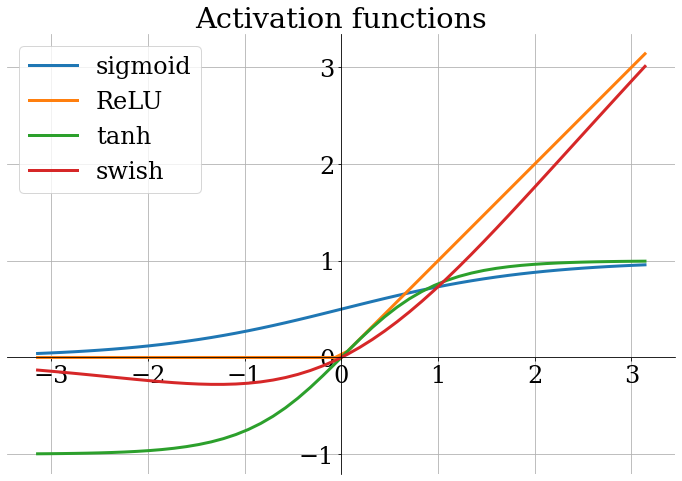

In [33]:
xtest = np.linspace(-np.pi,np.pi)

def centeraxis(ax):
    # Move left y-axis and bottim x-axis to centre, passing through (0,0)
    ax.spines['left'].set_position('zero')
    ax.spines['bottom'].set_position('zero')
    # Eliminate upper and right axes
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    # Show ticks in the left and lower axes only
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    ax.set_aspect('equal')

plt.figure(figsize=(10,10))
centeraxis(plt.gca())

plt.plot(xtest,tf.keras.activations.sigmoid(xtest), label='sigmoid', linewidth=3)
plt.plot(xtest,tf.keras.activations.relu(xtest), label='ReLU', linewidth=3)
plt.plot(xtest,tf.keras.activations.tanh(xtest), label='tanh', linewidth=3)
plt.plot(xtest,tf.keras.activations.swish(xtest), label='swish', linewidth=3)
plt.grid()
plt.legend()
plt.title("Activation functions");
plt.tight_layout();


## Dense ANNs

### Hysteresis-free

In [14]:
def _dr_NN_ar_predfunc(i,x,v,mat,model,Mrinv,hist):
    state = (x.reshape(1,-1)-mat.xr[0])
    fint_r_pred = model.predict(state)
    ar_pred = Mrinv @  (mat.fr[i] - fint_r_pred).T
    return ar_pred.T

def _dr_NN_trainfunc(mat, stop=501):
    x_train = (mat.xr - mat.xr[0])[:stop]    
    y_train = mat.fint_r[:stop]
    return x_train, y_train

dr_NN_trainfunc = NamedFunc(_dr_NN_trainfunc,     "Simple displacement-only trainfuc for dense networks")
dr_NN_ar_predfunc = NamedFunc(_dr_NN_ar_predfunc, "Simple displacement-only predfunc for dense networks")

Evaluating:
	Training Data:	Example2D(plate/plate_2_20_20)
	Prediction Model:	<keras.engine.sequential.Sequential object at 0x000001C9AAACB1C0>(Simple displacement-only trainfuc for dense networks, Reduced Internal force)
	Acceleration function:	Simple displacement-only predfunc for dense networks
	POD components:	4
	Training range:	0:500/501


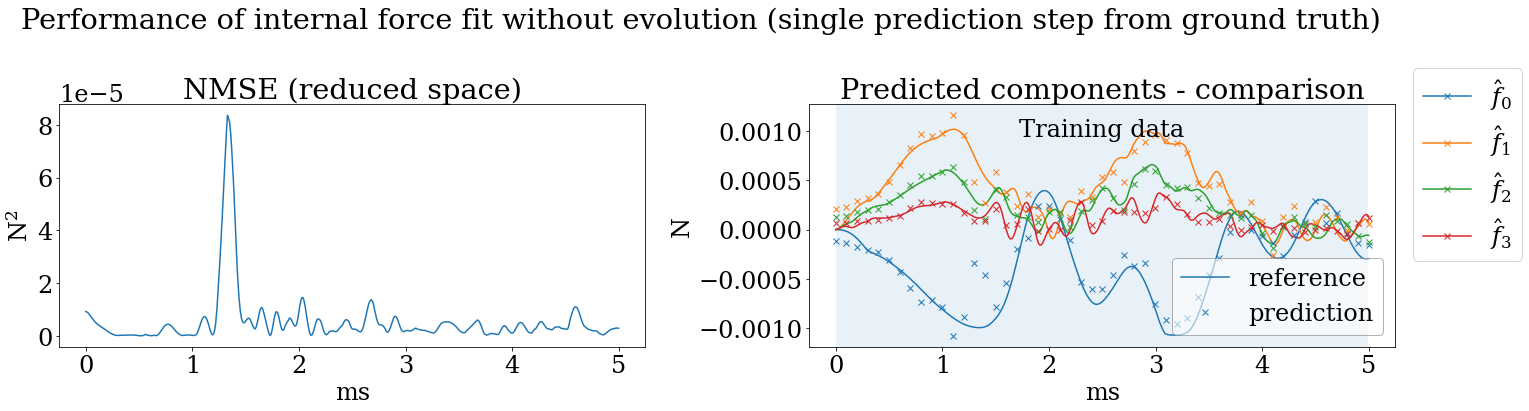

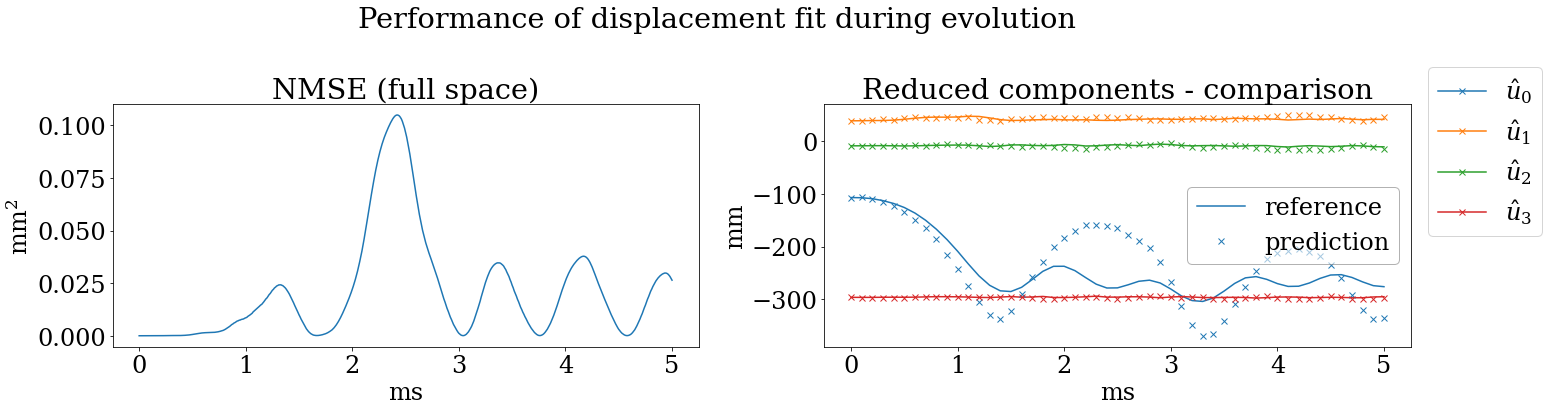

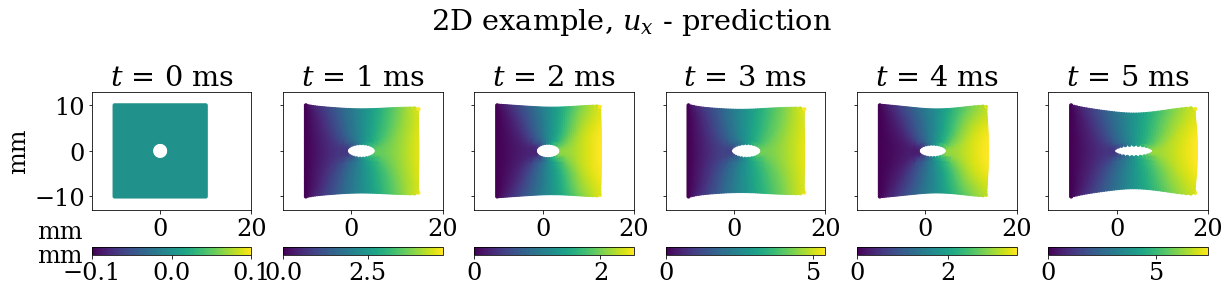

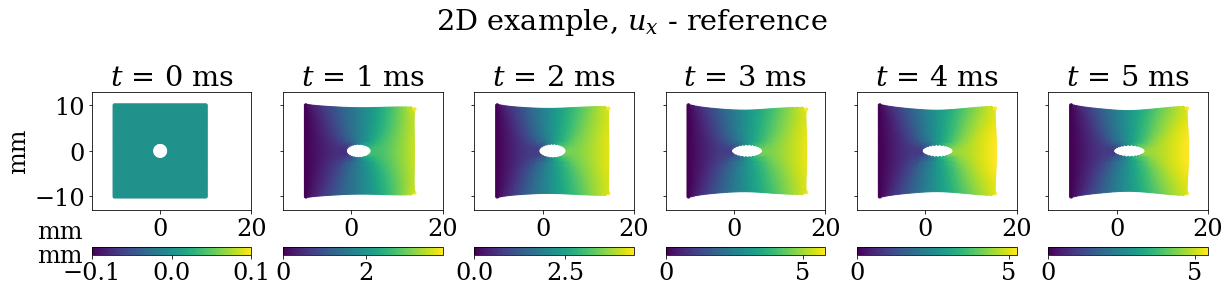

In [28]:
tf.random.set_seed(42)
fit_params = dict(batch_size=32, epochs=100,verbose=2,callbacks=[EpochProgbar(500)])
out = evaluate2D(mat2, tfDense(npod_x*2,npod_x,activations=['relu','linear'],learning_rate=0.1), dr_NN_trainfunc, dr_NN_trainfunc, dr_NN_ar_predfunc, npod_x, training_stop=500, fit_params=fit_params)

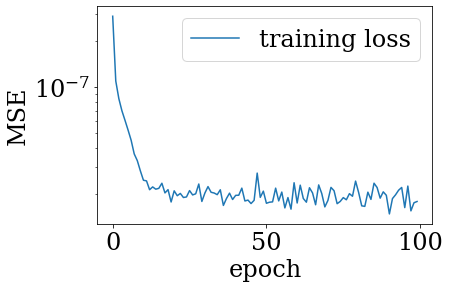

In [30]:
plt.semilogy(out['fit_history'].history['loss'],label='training loss')
plt.xlabel('epoch')
plt.ylabel("MSE")
#plt.semilogy(out['fit_history'].history['val_loss'],label='validation loss')
plt.legend();

### Plastic strain augmented

In [15]:
def drpeps_droldpeps_NN_trainfunc_base(mat, stop=501):
    nowpeps = mat.peps_r[:stop]
    oldpeps = np.pad(nowpeps,((1,0),(0,0)),'edge')[:-1]
    x_train = np.hstack([
                mat.xr[:stop] - mat.xr[0],
                oldpeps
            ])
    y_train = np.hstack([mat.fint_r[:stop],nowpeps])
    return x_train, y_train
    
drpeps_droldpeps_NN_trainfunc = NamedFunc(drpeps_droldpeps_NN_trainfunc_base,'Reduced displacement augmented with the previous effective plastic strain for NN')


def drpeps_drpeps_NN_ar_predfunc_base(i,x,v,mat,model,Mrinv,hist):

    if i == 0:
        hist.peps_r = mat.peps_r[0]
        hist.peps_r_log = np.zeros_like(mat.peps_r)
    
    try:
        augmented_state = np.hstack([x.reshape(1,-1)-mat.xr[0], hist.peps_r.reshape(1,-1)])
        augmented_output = model.predict(augmented_state.reshape(1,-1))

        fint_r_pred = augmented_output[:,:x.shape[1]]
        peps_r = augmented_output[:,x.shape[1]:]

        hist.peps_r = peps_r
        hist.peps_r_log[i] = peps_r
    except ValueError as e:
        print(f"ValueError during prediction at i={i}: '{e}'.\bnPredicting a=0 instead.")
        fint_r_pred = mat.fr[i]
    fr = mat.fr[i]
    ar_pred = Mrinv @  (fr - fint_r_pred).T
    return ar_pred.T

drpeps_drpeps_NN_ar_predfunc = NamedFunc(drpeps_drpeps_NN_ar_predfunc_base, 'Prediction from displacement augmented with the effective plastic strain all-in-one for NN')

In [16]:
def drpeps_droldpeps_ss_trainfunc_base(mat, stop=501):
    nowpeps = mat.peps_r[:stop]
    oldpeps = np.pad(nowpeps,((1,0),(0,0)),'edge')[:-1]
    x_train = np.hstack([
                xss_flat.transform_flat(mat.xr[:stop] - mat.xr[0]),
                ess_flat.transform_flat(oldpeps)
            ])
    y_train = np.hstack([fss_flat.transform_flat(mat.fint_r[:stop]),ess_flat.transform_flat(nowpeps)])
    return x_train, y_train
    
drpeps_droldpeps_ss_trainfunc = NamedFunc(drpeps_droldpeps_ss_trainfunc_base,'Reduced displacement augmented with the previous effective plastic strain with Scaling')


def drpeps_drpeps_ss_ar_predfunc_base(i,x,v,mat,model,Mrinv,hist):

    if i == 0:
        hist.peps_r = mat.peps_r[0]
        hist.peps_r_log = np.zeros_like(mat.peps_r)
        hist.fint_r_log = np.zeros_like(mat.fint_r)
    
    try:
        augmented_state = np.hstack([xss_flat.transform_flat(x.reshape(1,-1)-mat.xr[0]),
                                     ess_flat.transform_flat(hist.peps_r.reshape(1,-1))])
        augmented_output = model.predict(augmented_state.reshape(1,-1))

        fint_r_pred = fss_flat.inverse_transform_flat(augmented_output[:,:x.shape[1]])
        peps_r = ess_flat.inverse_transform_flat(augmented_output[:,x.shape[1]:])

        hist.peps_r = peps_r
        hist.peps_r_log[i] = peps_r
        hist.fint_r_log[i] = fint_r_pred
    except ValueError as e:
        print(f"ValueError during prediction at i={i}: '{e}'.\bnPredicting a=0 instead.")
        fint_r_pred = mat.fr[i]
    fr = mat.fr[i]
    ar_pred = Mrinv @  (fr - fint_r_pred).T
    return ar_pred.T

drpeps_drpeps_ss_ar_predfunc = NamedFunc(drpeps_drpeps_ss_ar_predfunc_base, 'Prediction from displacement augmented with the effective plastic strain all-in-one with Scaling')

Evaluating:
	Training Data:	Example2D(plate/plate_2_20_20)
	Prediction Model:	<keras.engine.sequential.Sequential object at 0x000001C78D899CD0>(Reduced displacement augmented with the previous effective plastic strain for NN, Reduced Internal force)
	Acceleration function:	Prediction from displacement augmented with the effective plastic strain all-in-one for NN
	POD components:	4
	Training range:	0:300/501
Epoch 100/50000
100/100 - 0s - loss: 0.1916 - val_loss: 0.1861 - 36ms/epoch - 360us/sample
Epoch 200/50000
100/100 - 0s - loss: 0.0850 - val_loss: 0.1128 - 26ms/epoch - 260us/sample
Epoch 300/50000
100/100 - 0s - loss: 0.0383 - val_loss: 0.0859 - 30ms/epoch - 299us/sample
Epoch 400/50000
100/100 - 0s - loss: 0.0169 - val_loss: 0.0706 - 32ms/epoch - 320us/sample
Epoch 500/50000
100/100 - 0s - loss: 0.0079 - val_loss: 0.0622 - 26ms/epoch - 259us/sample
Epoch 600/50000
100/100 - 0s - loss: 0.0042 - val_loss: 0.0573 - 49ms/epoch - 490us/sample
Epoch 700/50000
100/100 - 0s - loss: 0.0026

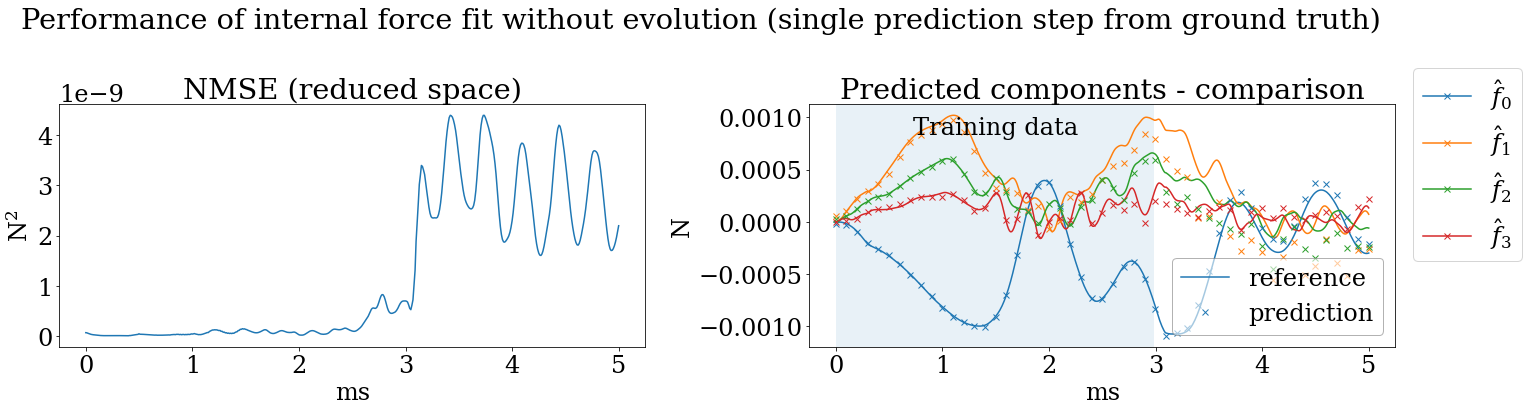

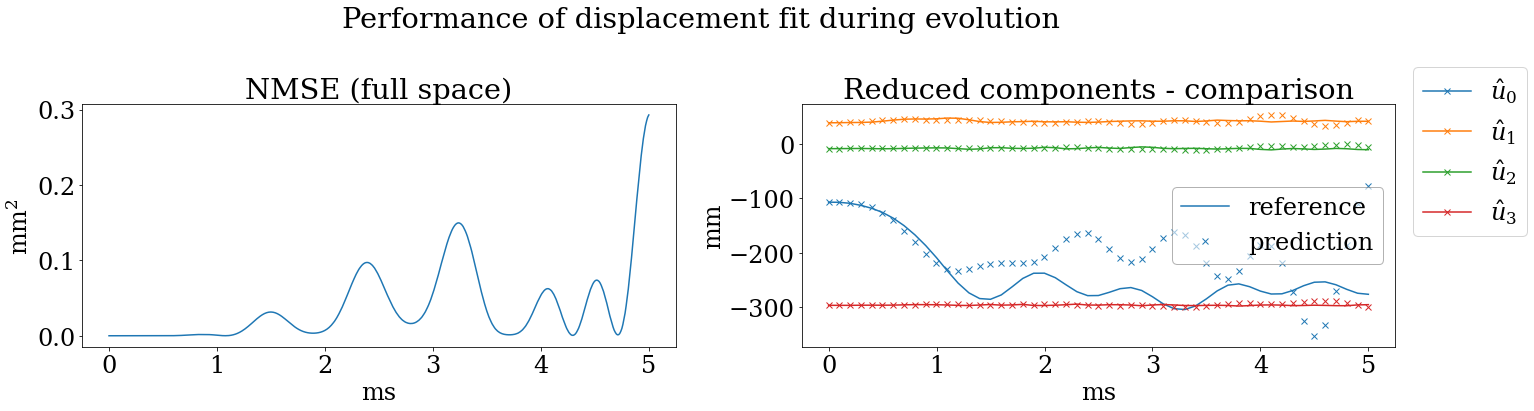

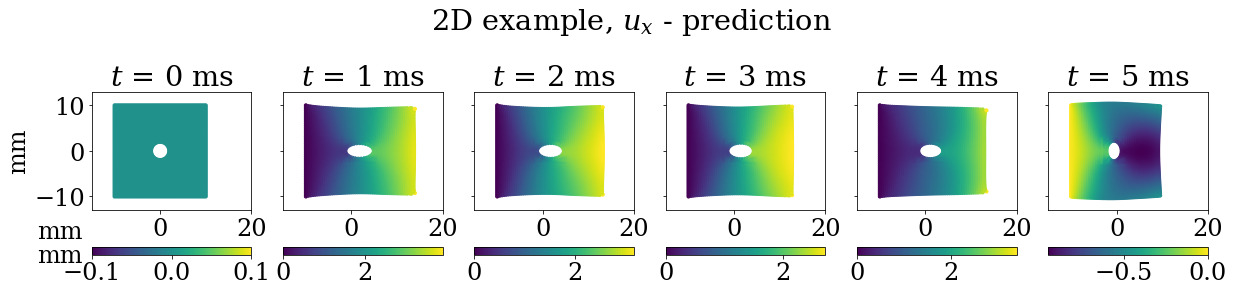

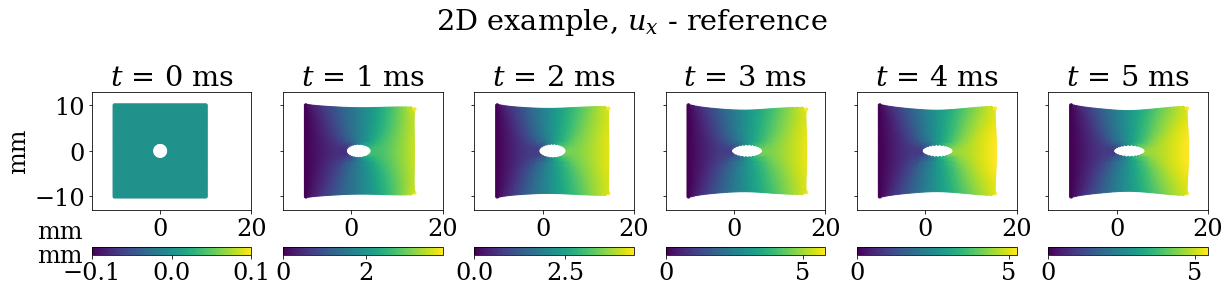

In [38]:

tf.random.set_seed(42)
fit_params = dict(batch_size=256, epochs=50000,verbose=2,validation_split=44/300,callbacks=[EpochProgbar(100),tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=1000,restore_best_weights=True)])
out = evaluate2D(mat2, tfDenseSplit(npod_x+npod_eps,tail_size=npod_eps,activations=['linear'],learning_rate=0.2),
                 drpeps_droldpeps_NN_trainfunc, drpeps_droldpeps_NN_trainfunc, drpeps_drpeps_NN_ar_predfunc,
                 pod_basis_size=npod_x, eps_basis_size=npod_eps, training_stop=300, fit_params=fit_params)

Evaluating:
	Training Data:	Example2D(plate/plate_2_20_20)
	Prediction Model:	<keras.engine.sequential.Sequential object at 0x000001C78D8DC520>(Reduced displacement augmented with the previous effective plastic strain for NN, Reduced Internal force)
	Acceleration function:	Prediction from displacement augmented with the effective plastic strain all-in-one for NN
	POD components:	4
	Training range:	0:300/501
Epoch 500/50000
500/500 - 0s - loss: 0.0086 - 3ms/epoch - 6us/sample
Epoch 1000/50000
500/500 - 0s - loss: 0.0015 - 4ms/epoch - 8us/sample
Epoch 1500/50000
500/500 - 0s - loss: 3.5176e-04 - 4ms/epoch - 8us/sample
Epoch 2000/50000
500/500 - 0s - loss: 2.4391e-04 - 5ms/epoch - 10us/sample
Epoch 2500/50000
500/500 - 0s - loss: 3.7353e-05 - 12ms/epoch - 24us/sample
Epoch 3000/50000
500/500 - 0s - loss: 0.0098 - 2ms/epoch - 4us/sample
Epoch 3500/50000
500/500 - 0s - loss: 3.0906e-05 - 6ms/epoch - 12us/sample
Epoch 4000/50000
500/500 - 0s - loss: 3.5734 - 3ms/epoch - 6us/sample
Epoch 4500

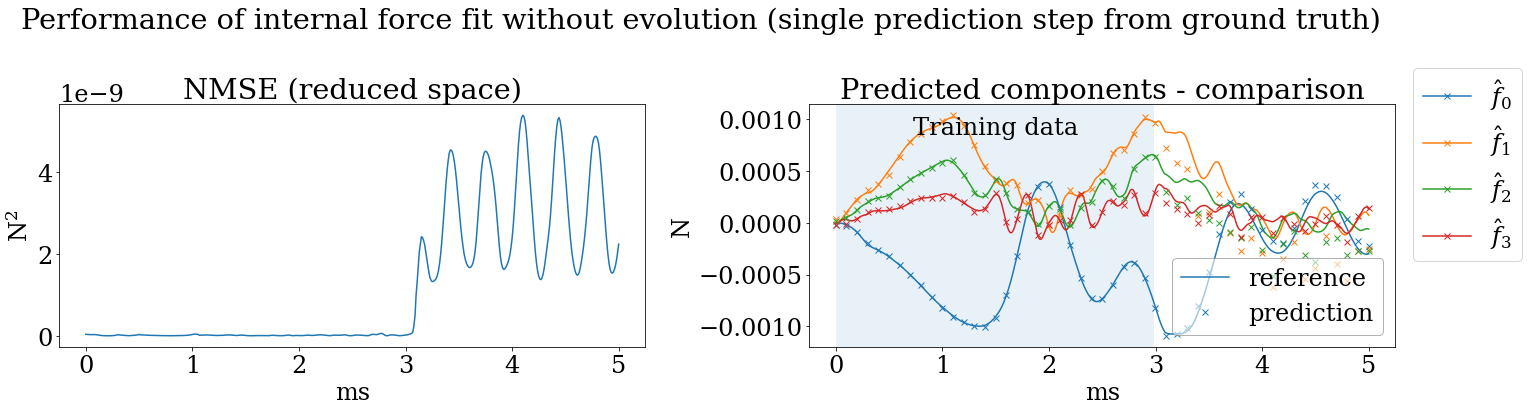

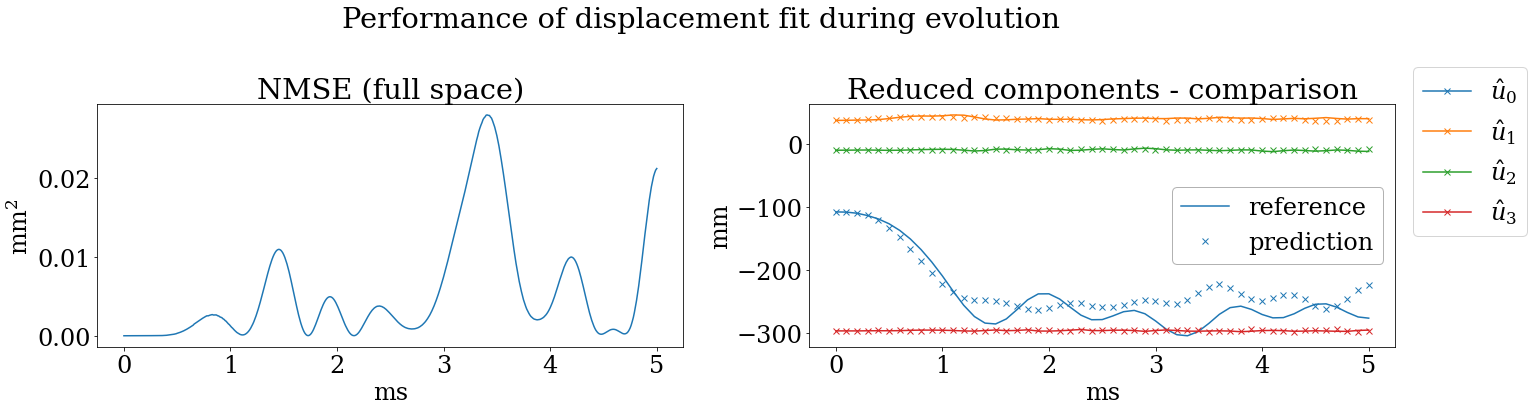

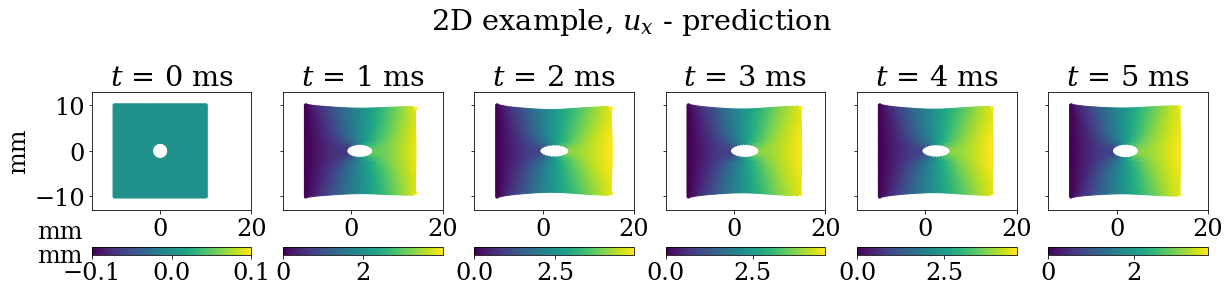

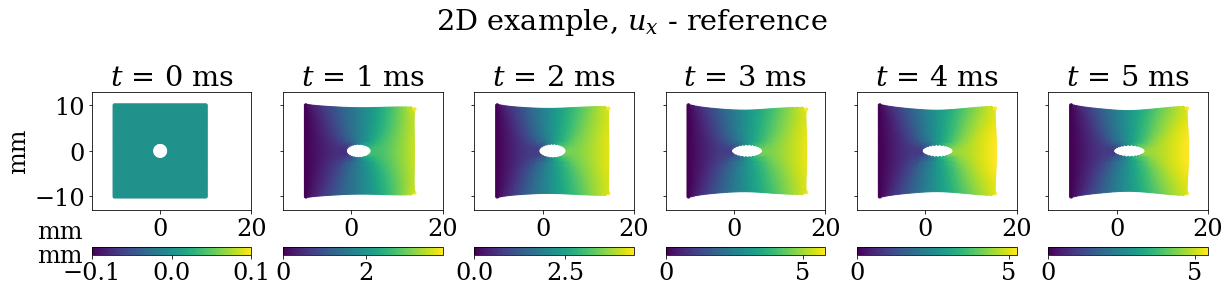

In [35]:

tf.random.set_seed(0)
fit_params = dict(batch_size=300, epochs=50000,verbose=2,callbacks=[EpochProgbar(500),tf.keras.callbacks.EarlyStopping(monitor='loss',patience=1000,restore_best_weights=True)])
out = evaluate2D(mat2, tfDenseSplit(npod_x+npod_eps,tail_size=npod_eps,activations=['linear'],learning_rate=0.2),
                 drpeps_droldpeps_NN_trainfunc, drpeps_droldpeps_NN_trainfunc, drpeps_drpeps_NN_ar_predfunc,
                 pod_basis_size=npod_x, eps_basis_size=npod_eps, training_stop=300, fit_params=fit_params)

Evaluating:
	Training Data:	Example2D(plate/plate_2_20_20)
	Prediction Model:	<keras.engine.sequential.Sequential object at 0x0000022EAA3553D0>(Reduced displacement augmented with the previous effective plastic strain with Scaling, Reduced Internal force)
	Acceleration function:	Prediction from displacement augmented with the effective plastic strain all-in-one with Scaling
	POD components:	4
	Training range:	0:300/501
Epoch 100/10000
100/100 - 0s - loss: 0.0183 - val_loss: 0.1854 - 29ms/epoch - 290us/sample
Epoch 200/10000
100/100 - 0s - loss: 0.0113 - val_loss: 0.2212 - 41ms/epoch - 410us/sample
Epoch 300/10000
100/100 - 0s - loss: 0.0107 - val_loss: 0.2117 - 27ms/epoch - 270us/sample
Epoch 400/10000
100/100 - 0s - loss: 0.0140 - val_loss: 0.2867 - 26ms/epoch - 257us/sample
Epoch 500/10000
100/100 - 0s - loss: 0.0087 - val_loss: 0.2207 - 27ms/epoch - 270us/sample
Epoch 600/10000
100/100 - 0s - loss: 0.0086 - val_loss: 0.2265 - 27ms/epoch - 274us/sample
Epoch 700/10000
100/100 - 0s - 

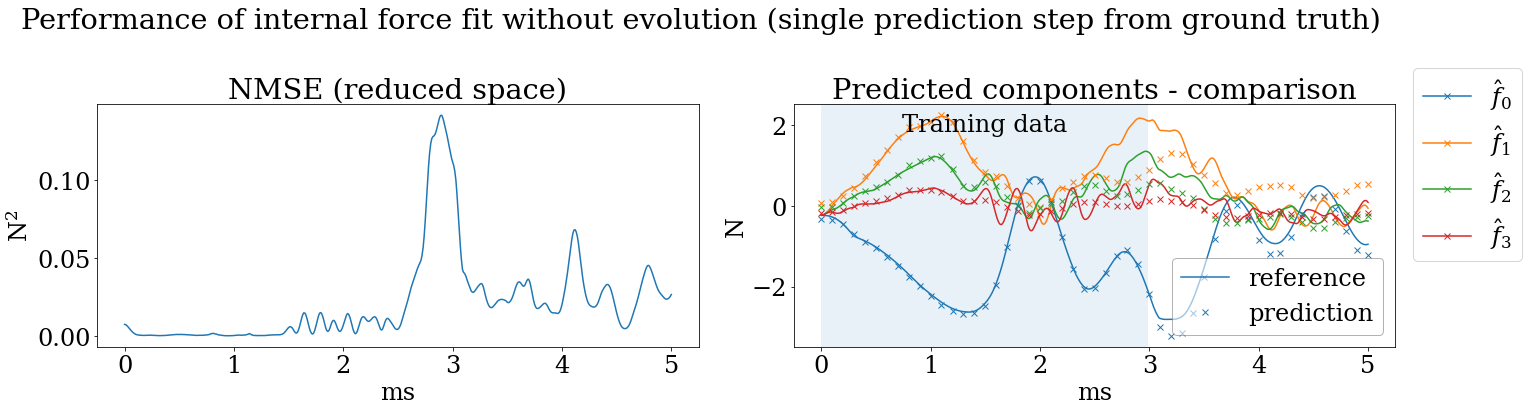

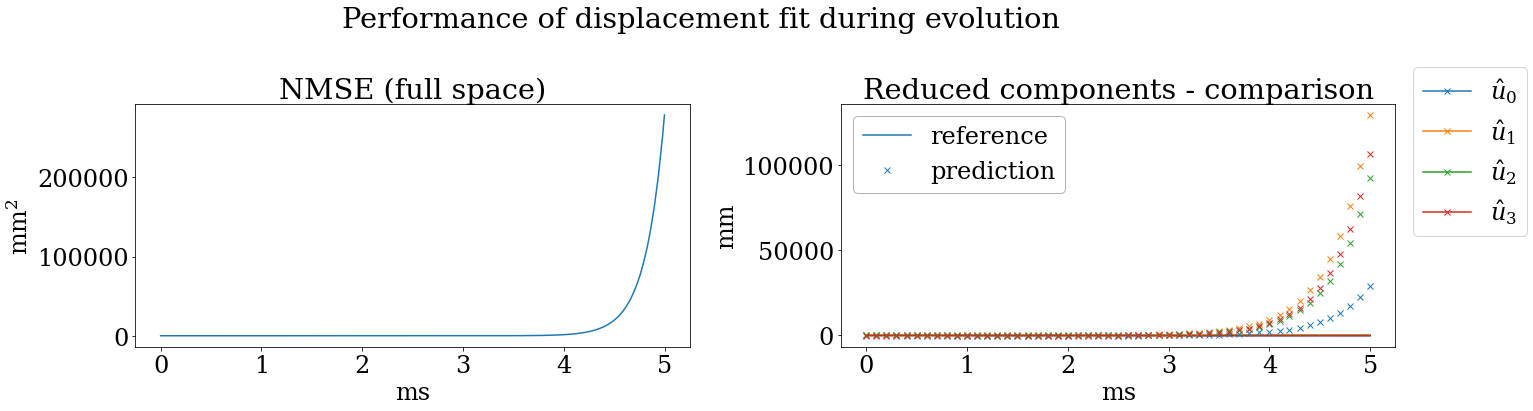

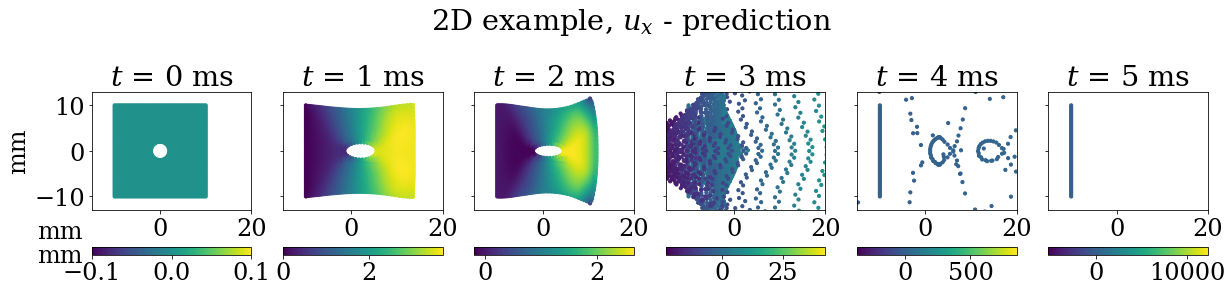

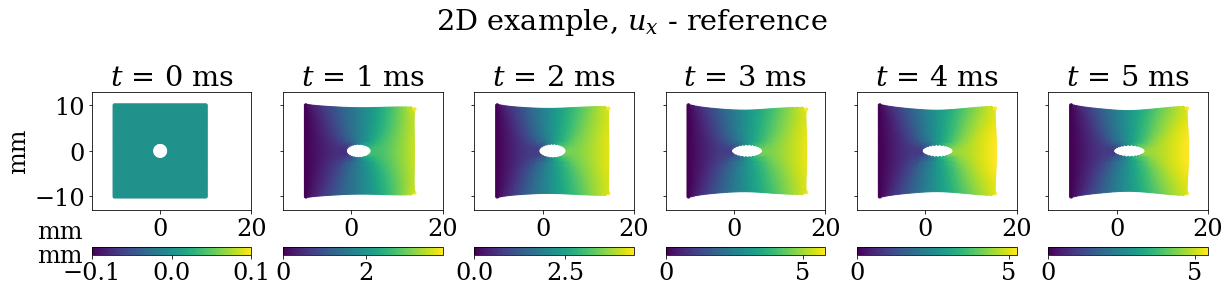

In [27]:
tf.random.set_seed(42)
fit_params = dict(batch_size=256, epochs=10000,verbose=2,validation_split=44/300,callbacks=[EpochProgbar(100),tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=1000)] )

out = evaluate2D(mat2, tfDenseRescale(64,npod_x+npod_eps,activations=['relu','linear'],learning_rate=0.1),
                 drpeps_droldpeps_ss_trainfunc, drpeps_droldpeps_ss_trainfunc, drpeps_drpeps_ss_ar_predfunc,
                 pod_basis_size=npod_x, eps_basis_size=npod_eps, training_stop=300, fit_params=fit_params, interrupt=False)

'Saved to ../animations/plastic_densenn_4pods.gif'

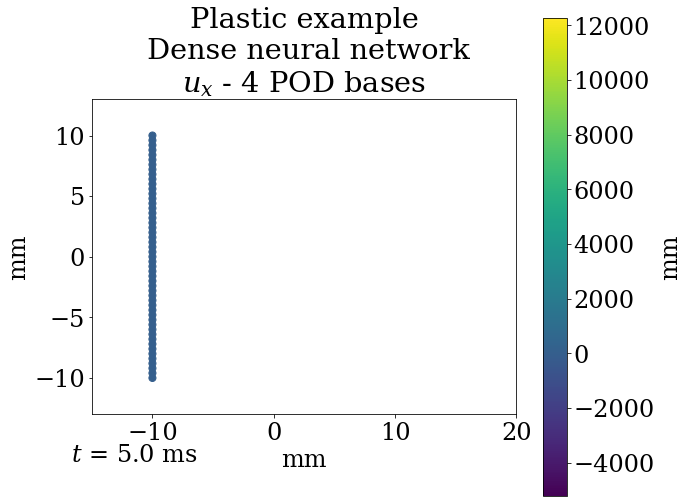

In [28]:
xroutinv = out['xroutinv']
dx_xroutinv = (xroutinv - xroutinv[0])[:,:xroutinv.shape[1]//2]
xx_xroutinv = mat2.xx[0] + xroutinv - xroutinv[0]
animatedplot2D(dx_xroutinv, xx_xroutinv[:,:xx_xroutinv.shape[1]//2],xx_xroutinv[:,xx_xroutinv.shape[1]//2:],
                path = "../animations/plastic_densenn_4pods",
                title = "Plastic example\n Dense neural network\n" r"$u_x$ - 4 POD bases",
               total_frames=250)

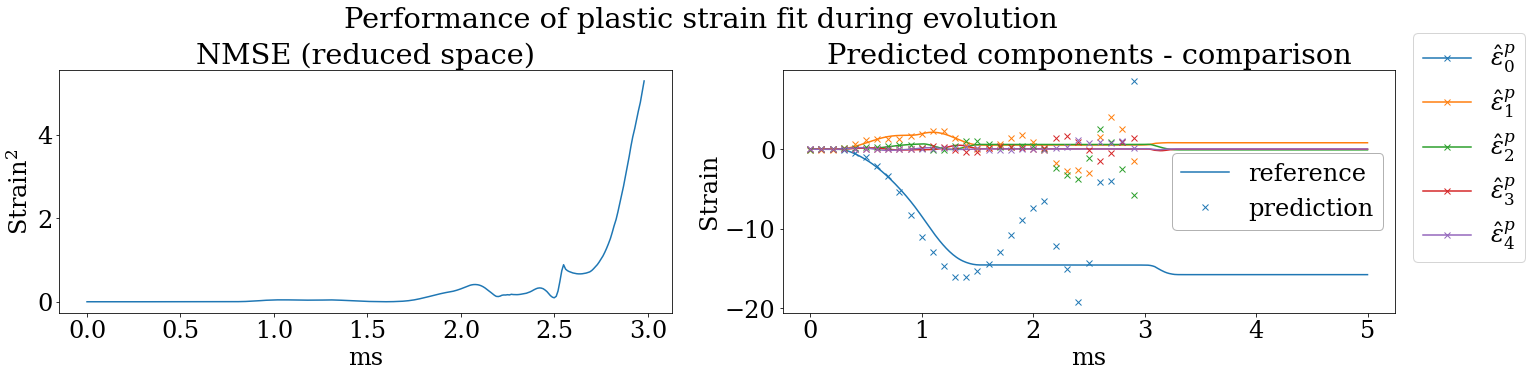

In [41]:
peps_test = out['hist'].peps_r_log[:300]
t = mat2.t
tt = t[:peps_test.shape[0]]
plt.figure(figsize=(20,6))
plt.subplot(121)
plt.plot(tt[:-1], (((peps_test-mat2.peps_r[:peps_test.shape[0]])**2).mean(axis=1)/(peps_test.max()-peps_test.min()))[:-1])
plt.xlabel("ms")
plt.ylabel(r"Strain$^2$")
plt.title(f"NMSE (reduced space)");
plt.subplot(122)
l1 = plt.plot(t,mat2.peps_r)[0]
plt.gca().set_prop_cycle(None)
l2 = plt.plot(tt[::10],peps_test[::10],'x')[0]
plt.xlabel('ms')
plt.ylabel('Strain')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
legend1 = plt.legend(handles=[pltl.Line2D([0], [0],
                                            marker='x',
                                            color=colors[i % len(colors)],
                                            label=rf"$\hat{{\varepsilon}}^p_{{{i}}}$") for i in range(mat2.peps_r.shape[1])],
                        loc="upper left",
                        bbox_to_anchor=(1.01,1.2))
plt.legend([l1,l2],['reference','prediction'],framealpha=0.6,edgecolor="gray")
plt.gca().add_artist(legend1)
plt.title("Predicted components - comparison")
plt.suptitle('Performance of plastic strain fit during evolution',y=0.9)
plt.tight_layout();

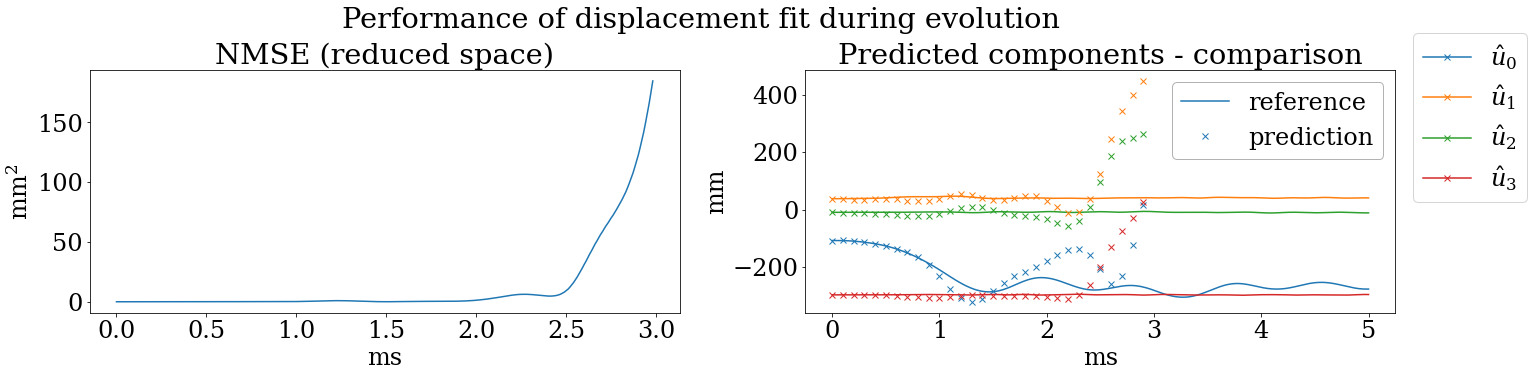

In [29]:
xrout = out['xrout'][:300]
t = mat2.t
tt = t[:xrout.shape[0]]
plt.figure(figsize=(20,6))
plt.subplot(121)
plt.plot(tt[:-1], (((xrout-mat2.xr[:xrout.shape[0]])**2).mean(axis=1)/(xrout.max()-xrout.min()))[:-1])
plt.xlabel("ms")
plt.ylabel(r"mm$^2$")
plt.title(f"NMSE (reduced space)");
plt.subplot(122)
l1 = plt.plot(t,mat2.xr)[0]
plt.gca().set_prop_cycle(None)
l2 = plt.plot(tt[::10],xrout[::10],'x')[0]
plt.xlabel('ms')
plt.ylabel('mm')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
legend1 = plt.legend(handles=[pltl.Line2D([0], [0],
                                            marker='x',
                                            color=colors[i % len(colors)],
                                            label=rf"$\hat{{u}}_{{{i}}}$") for i in range(mat2.xr.shape[1])],
                        loc="upper left",
                        bbox_to_anchor=(1.01,1.2))
plt.legend([l1,l2],['reference','prediction'],framealpha=0.6,edgecolor="gray")
plt.gca().add_artist(legend1)
plt.title("Predicted components - comparison")
plt.suptitle('Performance of displacement fit during evolution',y=0.9)
plt.tight_layout();

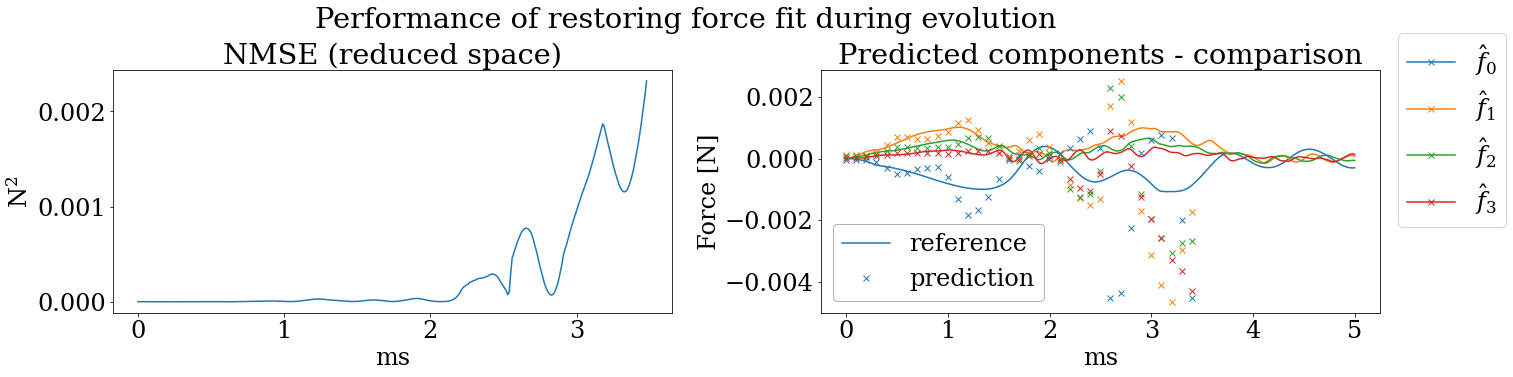

In [38]:
fint_test = out['hist'].fint_r_log[:350]
tt = t[:fint_test.shape[0]]
plt.figure(figsize=(20,6))
plt.subplot(121)
plt.plot(tt[:-1], (((fint_test-mat2.fint_r[:fint_test.shape[0]])**2).mean(axis=1)/(fint_test.max()-fint_test.min()))[:-1])
plt.xlabel("ms")
plt.ylabel(r"N$^2$")
plt.title(f"NMSE (reduced space)");
plt.subplot(122)
l1 = plt.plot(t,mat2.fint_r)[0]
plt.gca().set_prop_cycle(None)
l2 = plt.plot(tt[::10],fint_test[::10],'x')[0]
plt.xlabel('ms')
plt.ylabel('Force [N]')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
legend1 = plt.legend(handles=[pltl.Line2D([0], [0],
                                            marker='x',
                                            color=colors[i % len(colors)],
                                            label=rf"$\hat{{f}}_{{{i}}}$") for i in range(mat2.fint_r.shape[1])],
                        loc="upper left",
                        bbox_to_anchor=(1.01,1.2))
plt.legend([l1,l2],['reference','prediction'],framealpha=0.6,edgecolor="gray")
plt.gca().add_artist(legend1)
plt.title("Predicted components - comparison")
plt.suptitle('Performance of restoring force fit during evolution',y=0.9)
plt.tight_layout();

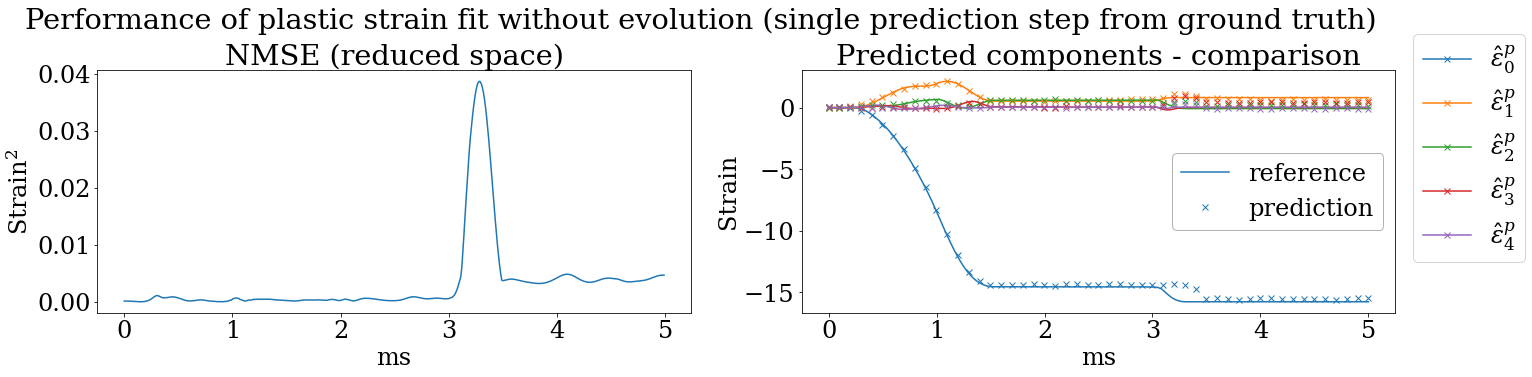

In [40]:
test_data = np.hstack([xss_flat.transform_flat(mat2.xr - mat2.xr[0]),
                       ess_flat.transform_flat(np.pad(mat2.peps_r,((1,0),(0,0)),'edge')[:-1])])
peps_test = ess_flat.inverse_transform_flat(out['model'].predict(test_data))[:,npod_x:]
t = mat2.t
tt = t[:peps_test.shape[0]]
plt.figure(figsize=(20,6))
plt.subplot(121)
plt.plot(tt[:-1], (((peps_test-mat2.peps_r[:peps_test.shape[0]])**2).mean(axis=1)/(peps_test.max()-peps_test.min()))[:-1])
plt.xlabel("ms")
plt.ylabel(r"Strain$^2$")
plt.title(f"NMSE (reduced space)");
plt.subplot(122)
l1 = plt.plot(t,mat2.peps_r)[0]
plt.gca().set_prop_cycle(None)
l2 = plt.plot(tt[::10],peps_test[::10],'x')[0]
plt.xlabel('ms')
plt.ylabel('Strain')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
legend1 = plt.legend(handles=[pltl.Line2D([0], [0],
                                            marker='x',
                                            color=colors[i % len(colors)],
                                            label=rf"$\hat{{\varepsilon}}^p_{{{i}}}$") for i in range(mat2.peps_r.shape[1])],
                        loc="upper left",
                        bbox_to_anchor=(1.01,1.2))
plt.legend([l1,l2],['reference','prediction'],framealpha=0.6,edgecolor="gray")
plt.gca().add_artist(legend1)
plt.title("Predicted components - comparison")
plt.suptitle('Performance of plastic strain fit without evolution (single prediction step from ground truth)',y=0.9)
plt.tight_layout();

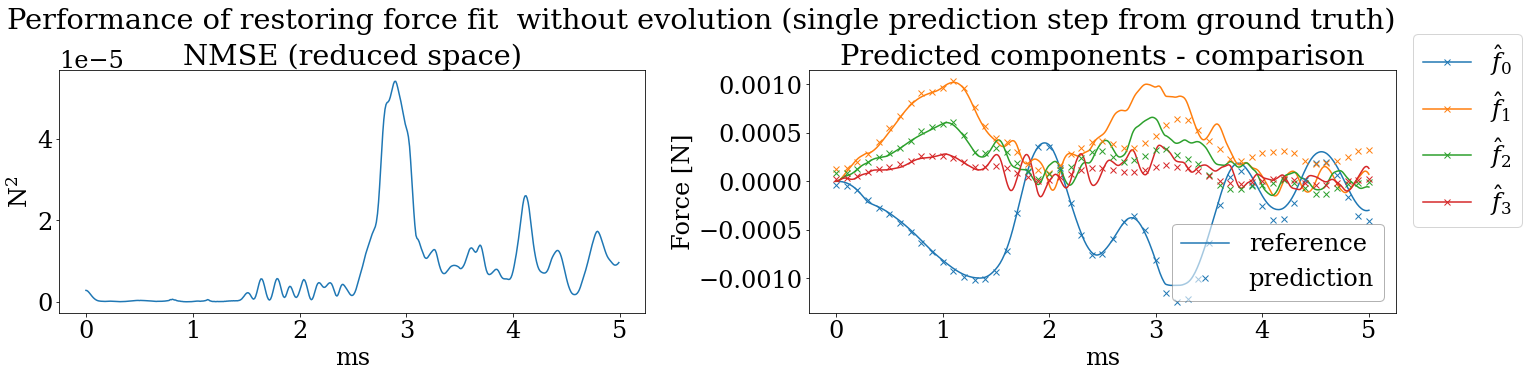

In [44]:
test_data = np.hstack([xss_flat.transform_flat(mat2.xr - mat2.xr[0]),
                       ess_flat.transform_flat(np.pad(mat2.peps_r,((1,0),(0,0)),'edge')[:-1])])
fint_test = fss_flat.inverse_transform_flat(out['model'].predict(test_data))[:,:npod_x]
tt = t[:fint_test.shape[0]]
plt.figure(figsize=(20,6))
plt.subplot(121)
plt.plot(tt[:-1], (((fint_test-mat2.fint_r[:fint_test.shape[0]])**2).mean(axis=1)/(fint_test.max()-fint_test.min()))[:-1])
plt.xlabel("ms")
plt.ylabel(r"N$^2$")
plt.title(f"NMSE (reduced space)");
plt.subplot(122)
l1 = plt.plot(t,mat2.fint_r)[0]
plt.gca().set_prop_cycle(None)
l2 = plt.plot(tt[::10],fint_test[::10],'x')[0]
plt.xlabel('ms')
plt.ylabel('Force [N]')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
legend1 = plt.legend(handles=[pltl.Line2D([0], [0],
                                            marker='x',
                                            color=colors[i % len(colors)],
                                            label=rf"$\hat{{f}}_{{{i}}}$") for i in range(mat2.fint_r.shape[1])],
                        loc="upper left",
                        bbox_to_anchor=(1.01,1.2))
plt.legend([l1,l2],['reference','prediction'],framealpha=0.6,edgecolor="gray")
plt.gca().add_artist(legend1)
plt.title("Predicted components - comparison")
plt.suptitle('Performance of restoring force fit  without evolution (single prediction step from ground truth)',y=0.9)
plt.tight_layout();

Evaluating:
	Training Data:	Example2D(plate/plate_2_20_20)
	Prediction Model:	<keras.engine.sequential.Sequential object at 0x0000025737AED580>(Reduced displacement augmented with the previous effective plastic strain with Scaling, Reduced Internal force)
	Acceleration function:	Prediction from displacement augmented with the effective plastic strain all-in-one with Scaling
	POD components:	4
	Training range:	0:300/501
Epoch 100/10000
100/100 - 0s - loss: 0.0223 - val_loss: 0.2242 - 30ms/epoch - 300us/sample
Epoch 200/10000
100/100 - 0s - loss: 0.0122 - val_loss: 0.2223 - 33ms/epoch - 330us/sample
Epoch 300/10000
100/100 - 0s - loss: 0.0113 - val_loss: 0.2341 - 28ms/epoch - 275us/sample
Epoch 400/10000
100/100 - 0s - loss: 0.0105 - val_loss: 0.2198 - 29ms/epoch - 285us/sample
Epoch 500/10000
100/100 - 0s - loss: 0.0104 - val_loss: 0.2326 - 34ms/epoch - 340us/sample
Epoch 600/10000
100/100 - 0s - loss: 0.0106 - val_loss: 0.2467 - 32ms/epoch - 319us/sample
Epoch 700/10000
100/100 - 0s - 

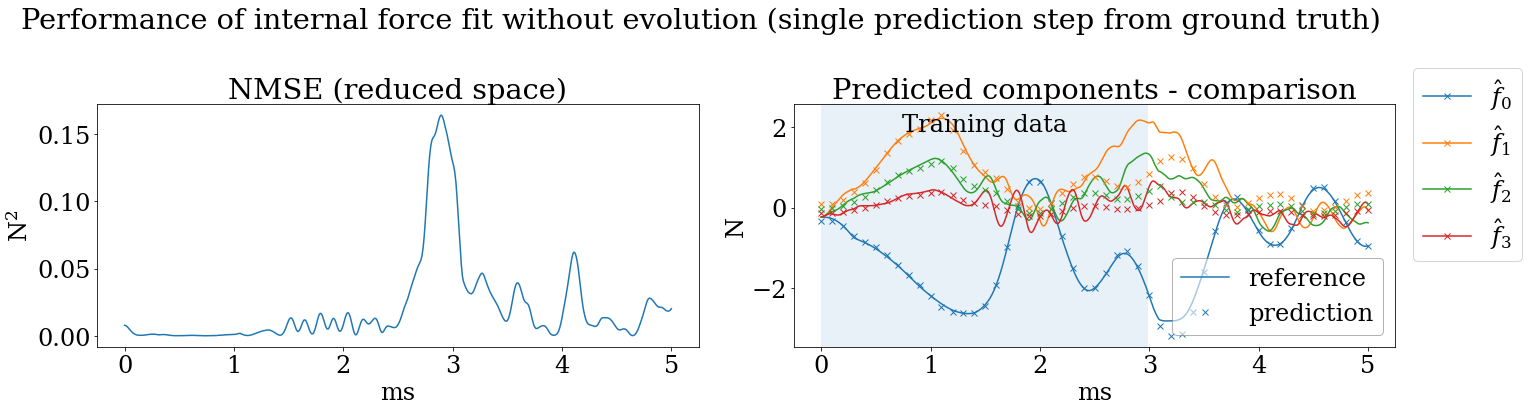

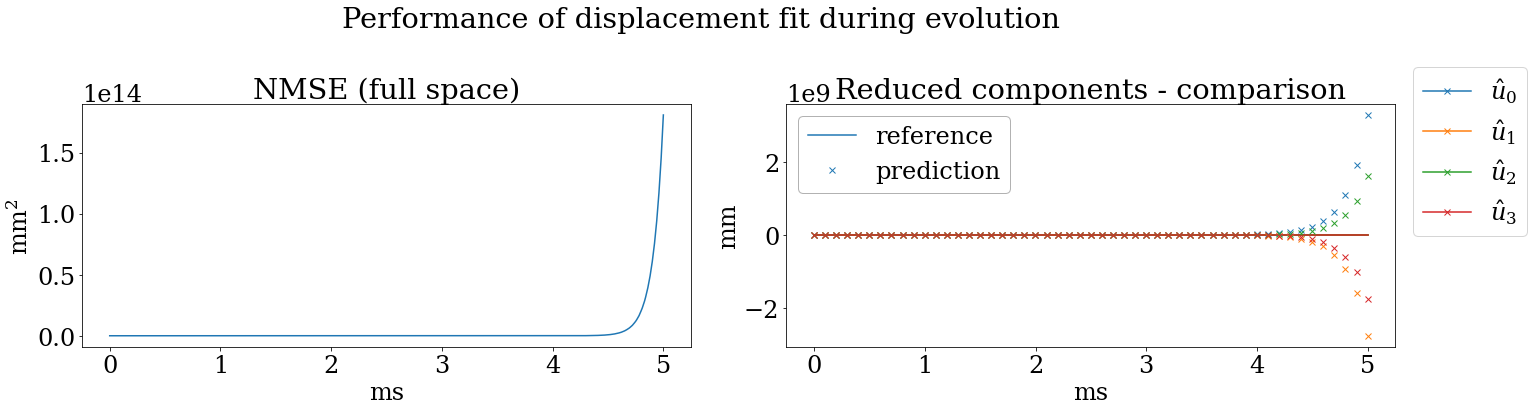

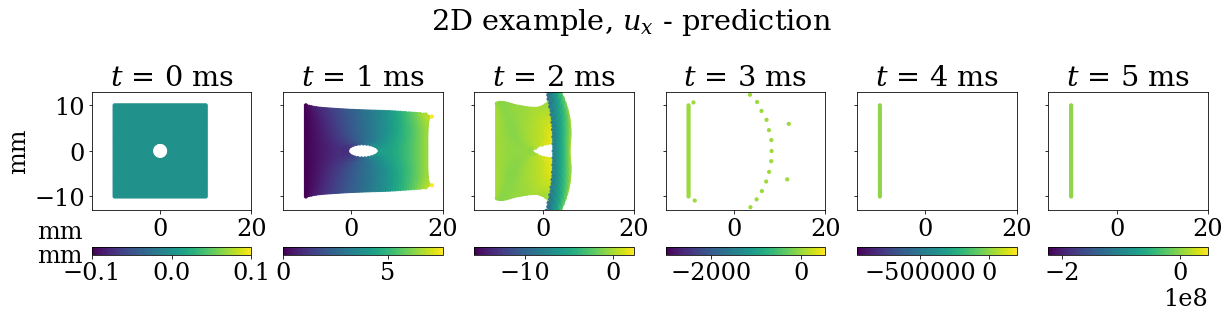

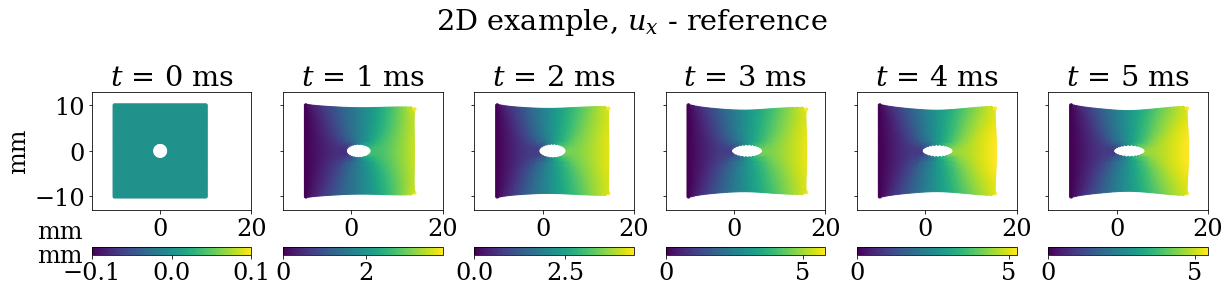

In [22]:
tf.random.set_seed(0)
fit_params = dict(batch_size=256, epochs=10000,verbose=2,validation_split=44/300,callbacks=[EpochProgbar(100),tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=1000)] )

out = evaluate2D(mat2, tfDenseRescale(64,npod_x+npod_eps,activations=['relu','linear'],learning_rate=0.1),
                 drpeps_droldpeps_ss_trainfunc, drpeps_droldpeps_ss_trainfunc, drpeps_drpeps_ss_ar_predfunc,
                 pod_basis_size=npod_x, eps_basis_size=npod_eps, training_stop=300, fit_params=fit_params, interrupt=False)

Evaluating:
	Training Data:	Example2D(plate/plate_2_20_20)
	Prediction Model:	<keras.engine.sequential.Sequential object at 0x0000025737BDF850>(Reduced displacement augmented with the previous effective plastic strain with Scaling, Reduced Internal force)
	Acceleration function:	Prediction from displacement augmented with the effective plastic strain all-in-one with Scaling
	POD components:	4
	Training range:	0:300/501
Epoch 100/10000
1000/1000 - 0s - loss: 0.0323 - 25ms/epoch - 25us/sample
Epoch 200/10000
1000/1000 - 0s - loss: 0.0288 - 19ms/epoch - 19us/sample
Epoch 300/10000
1000/1000 - 0s - loss: 0.0230 - 15ms/epoch - 15us/sample
Epoch 400/10000
1000/1000 - 0s - loss: 0.0150 - 27ms/epoch - 27us/sample
Epoch 500/10000
1000/1000 - 0s - loss: 0.0109 - 25ms/epoch - 25us/sample
Epoch 600/10000
1000/1000 - 0s - loss: 0.0112 - 16ms/epoch - 16us/sample
Epoch 700/10000
1000/1000 - 0s - loss: 0.0076 - 29ms/epoch - 29us/sample
Epoch 800/10000
1000/1000 - 0s - loss: 0.0146 - 16ms/epoch - 16us/

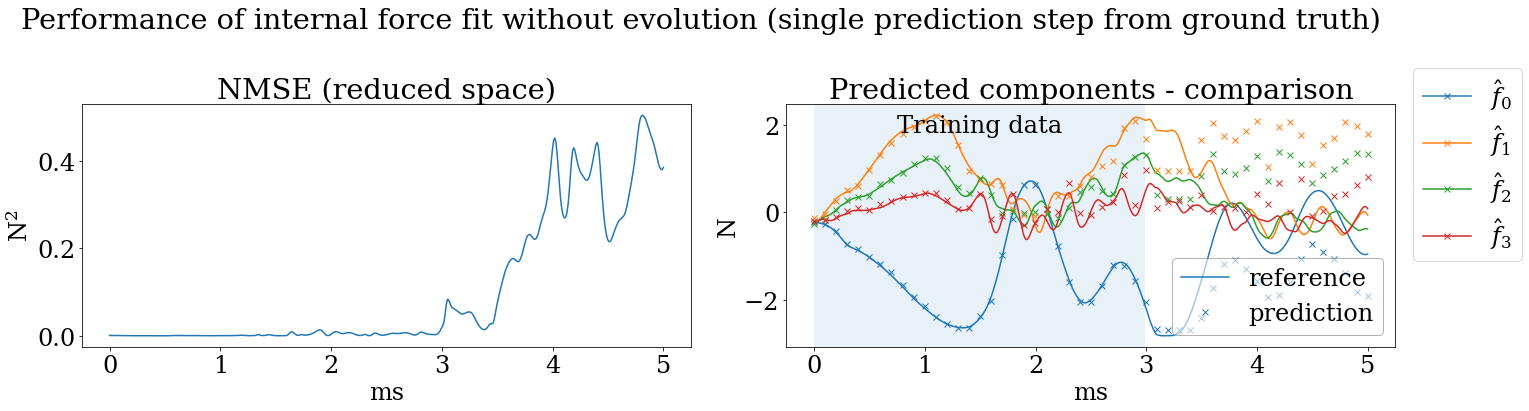

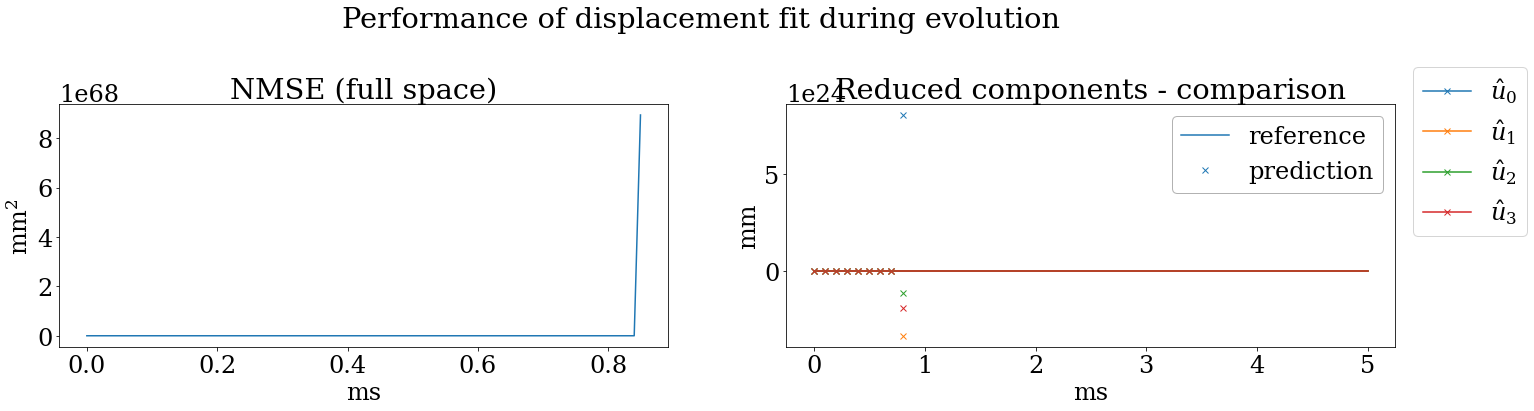

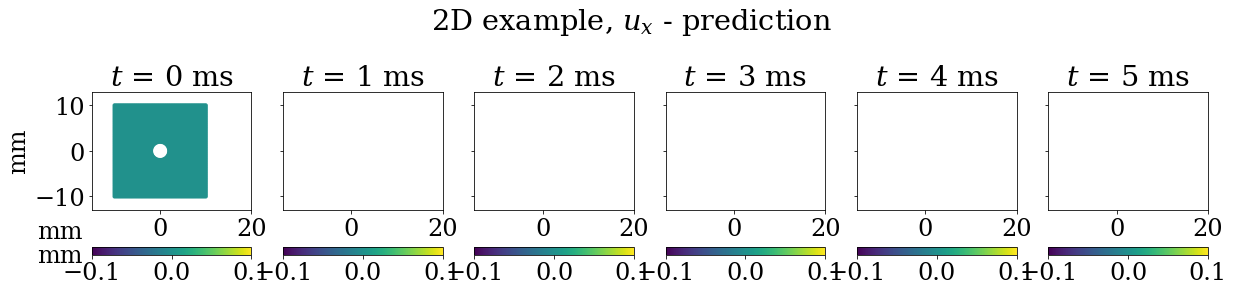

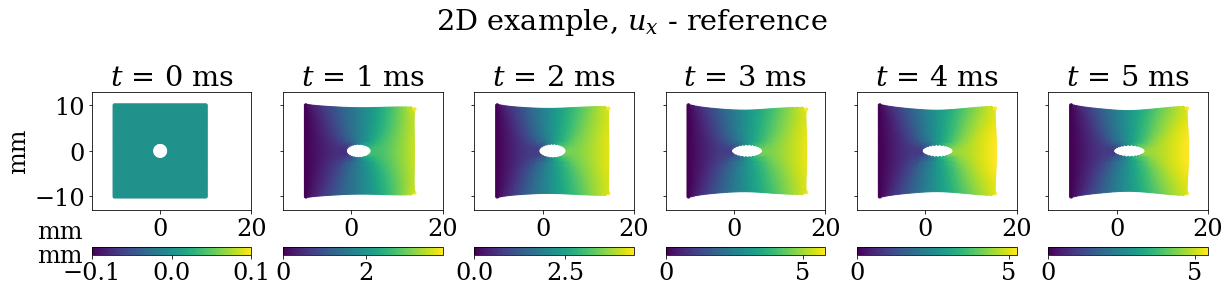

In [18]:
tf.random.set_seed(0)
fit_params = dict(batch_size=32, epochs=10000,verbose=2,callbacks=[EpochProgbar(100),tf.keras.callbacks.EarlyStopping(monitor='loss',patience=1000,restore_best_weights=True)],
                  #class_weight = {k:v for k,v in enumerate([1]*npod_x+[1]*npod_eps)}
                  #class_weight = {k:v for k,v in enumerate(ssin.mean_)}
                  )

out = evaluate2D(mat2, tfDenseRescale(9,9,9,npod_x+npod_eps,activations=['swish','swish','swish','linear'],learning_rate=0.1),
                 drpeps_droldpeps_ss_trainfunc, drpeps_droldpeps_ss_trainfunc, drpeps_drpeps_ss_ar_predfunc,
                 pod_basis_size=npod_x, eps_basis_size=npod_eps, training_stop=300, fit_params=fit_params, interrupt=False)

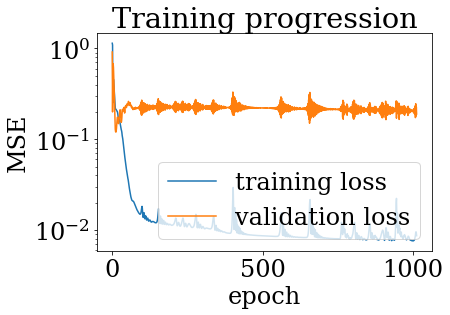

In [27]:
plt.figure()
plt.semilogy(out['fit_history'].history['loss'],label='training loss')
try:
    plt.semilogy(out['fit_history'].history['val_loss'],label='validation loss')
except:
    pass
plt.xlabel('epoch')
plt.ylabel("MSE")
plt.legend()
plt.title("Training progression");

### Delay embedding

## RNNs

In [22]:
def dr_oldf_ss_trainfunc_base(mat, stop=501, timesteps=1,interval=1):

    fint = fss_flat.transform_flat(mat.fint_r[:stop])
    dr = xss_flat.transform_flat(mat.xr[:stop] - mat.xr[0])

    te = gt.TakensEmbedding(time_delay=interval, dimension=timesteps+1)
    allfint = te.fit_transform(takens_pad(fint,interval,timesteps+1)).transpose(1,2,0)
    alldr = te.fit_transform(takens_pad(dr,interval,timesteps+1)).transpose(1,2,0)
    
    oldfint = allfint[:,:-1,:]
    newfint = allfint[:,-1,:]
    curdr = alldr[:,:-1,:]
    
    x_train = np.concatenate([curdr,oldfint],axis=2)
    y_train = newfint#np.hstack([newfint, alldr[:,-1,:]])
    
    return x_train, y_train

def dr_oldf_ss_ar_predfunc_base(i,x,v,mat,model,Mrinv,hist,timesteps=1,interval=1):
    offset = timesteps*interval
    if i == 0:
        hist.fint_r = np.pad(np.zeros_like(mat.fint_r),((offset,0),(0,0)),constant_values=((mat.fint_r[0],0),(0,0)))
        hist_dr = np.pad(np.zeros_like(mat.xr),((offset,0),(0,0)),constant_values=((mat.xr[0]-mat.xr[0],0),(0,0)))
        hist.dr_t = xss_flat.transform_flat(hist_dr)
        hist.fint_r_log = np.zeros_like(mat.fint_r)
    
    try:
        hist.dr_t[i+offset] = xss_flat.transform_flat(x - mat.xr[0])
        
        augmented_state = np.concatenate([hist.dr_t[i+interval:i+offset+1:interval],
              fss_flat.transform_flat(hist.fint_r[i:i+offset-interval+1:interval])])
        augmented_output = model.predict(augmented_state.reshape(1,timesteps,-1))

        fint_r_pred = fss_flat.inverse_transform_flat(augmented_output[:,:x.shape[1]])

        hist.fint_r[i+offset] = fint_r_pred
        hist.fint_r_log[i] = fint_r_pred
    except ValueError as e:
        print(f"ValueError during prediction at i={i}: '{e}'.\bnPredicting a=0 instead.")
        fint_r_pred = mat.fr[i]
    fr = mat.fr[i]
    ar_pred = Mrinv @  (fr - fint_r_pred).T
    return ar_pred.T

dr_oldf_ss_trainfunc = NamedFunc(dr_oldf_ss_trainfunc_base,'Reduced displacement augmented with the previous step restoring force with Scaling')
dr_oldf_ss_ar_predfunc = NamedFunc(dr_oldf_ss_ar_predfunc_base, 'Prediction from displacement augmented with the previous step restoring force with Scaling')

In [23]:
def dr_oldf_ss_factory(timesteps, interval):
    trainfunc = NamedFunc(lambda *args,**kwargs: dr_oldf_ss_trainfunc_base(*args,**kwargs, timesteps=timesteps, interval=interval),
                        f'Reduced displacement augmented with {timesteps} previous steps at interval {interval} step of restoring force with Scaling')
    ar_predfunc = NamedFunc(lambda *args,**kwargs: dr_oldf_ss_ar_predfunc_base(*args,**kwargs, timesteps=timesteps, interval=interval),
                        f'Prediction from displacement augmented with {timesteps} previous steps at interval {interval} step of restoring force with Scaling')
    return trainfunc, trainfunc, ar_predfunc

Evaluating:
	Training Data:	Example2D(plate/plate_2_20_20)
	Prediction Model:	<keras.engine.sequential.Sequential object at 0x0000018247817100>(Reduced displacement augmented with 4 previous steps at interval 6 step of restoring force with Scaling, Reduced Internal force)
	Acceleration function:	Prediction from displacement augmented with 4 previous steps at interval 6 step of restoring force with Scaling
	POD components:	4
	Training range:	0:300/501
Epoch 100/5000
100/100 - 0s - loss: 0.0083 - val_loss: 0.3963 - 49ms/epoch - 490us/sample
Epoch 200/5000
100/100 - 0s - loss: 0.0037 - val_loss: 0.4534 - 45ms/epoch - 450us/sample
Epoch 300/5000
100/100 - 0s - loss: 0.0023 - val_loss: 0.4455 - 56ms/epoch - 559us/sample
Epoch 400/5000
100/100 - 0s - loss: 9.3636e-04 - val_loss: 0.4538 - 37ms/epoch - 370us/sample
Epoch 500/5000
100/100 - 0s - loss: 0.0028 - val_loss: 0.4625 - 48ms/epoch - 480us/sample


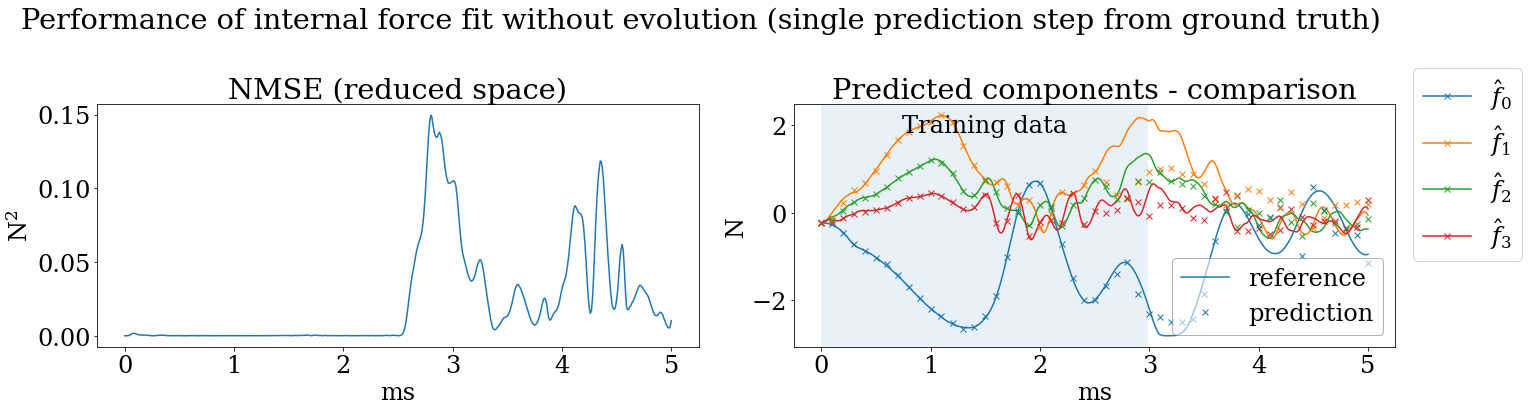

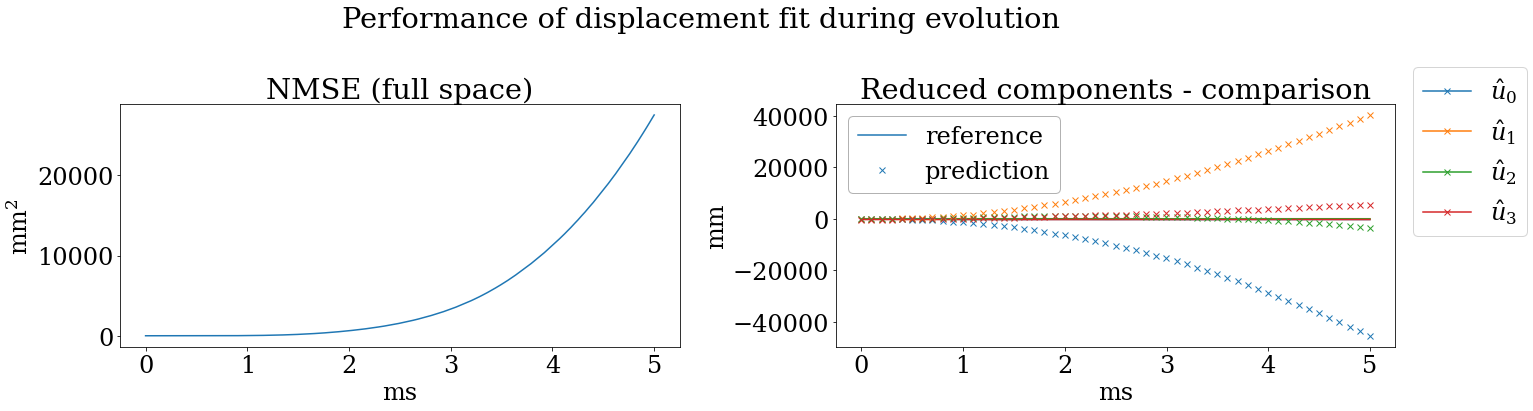

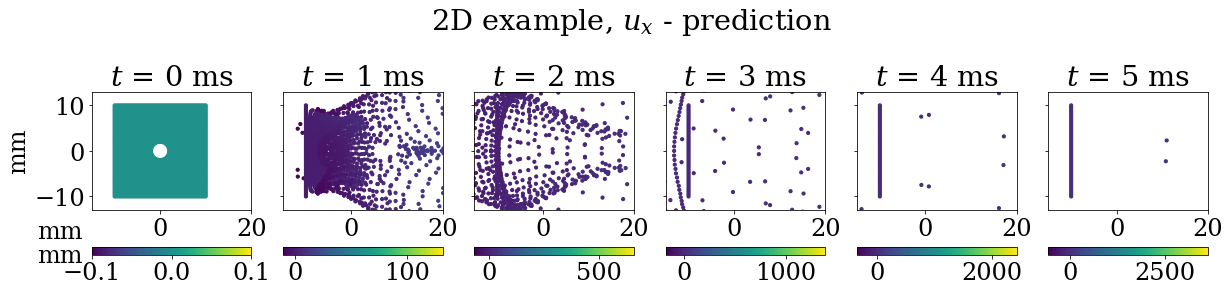

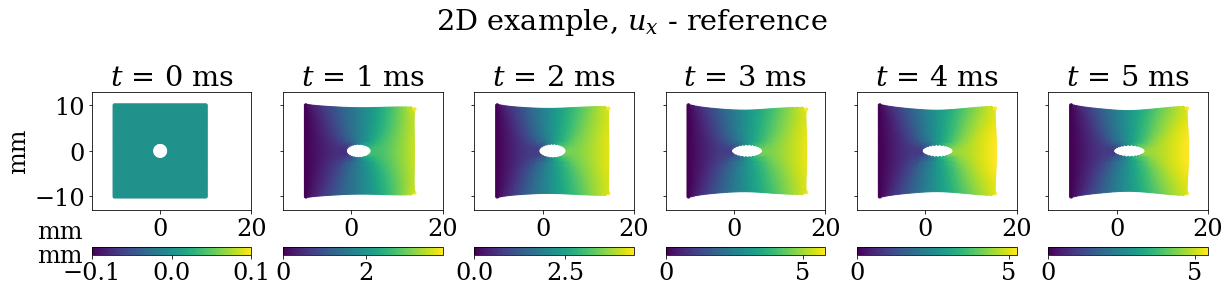

In [83]:
tf.random.set_seed(0)
fit_params = dict(batch_size=256, epochs=5000,verbose=2,validation_split=44/300,
                  callbacks=[EpochProgbar(100),tf.keras.callbacks.EarlyStopping(monitor='loss',patience=100,restore_best_weights=True)],
                  sample_weight=np.array([100] + [1]*299))

out = evaluate2D(mat2, tfRNN(npod_x,rnn_sizes=[32],rnn_activations=["tanh"],learning_rate=0.1),
                 *dr_oldf_ss_factory(4,6),
                 pod_basis_size=npod_x, training_stop=300, fit_params=fit_params, interrupt=False)

Evaluating:
	Training Data:	Example2D(plate/plate_2_20_20)
	Prediction Model:	<keras.engine.sequential.Sequential object at 0x000001820FEB0310>(Reduced displacement augmented with 9 previous steps at interval 6 step of restoring force with Scaling, Reduced Internal force)
	Acceleration function:	Prediction from displacement augmented with 9 previous steps at interval 6 step of restoring force with Scaling
	POD components:	4
	Training range:	0:300/501
Epoch 100/5000
100/100 - 0s - loss: 0.0272 - val_loss: 0.0443 - 35ms/epoch - 350us/sample
Epoch 200/5000
100/100 - 0s - loss: 0.0163 - val_loss: 0.0583 - 44ms/epoch - 440us/sample
Epoch 300/5000
100/100 - 0s - loss: 0.0112 - val_loss: 0.0566 - 34ms/epoch - 342us/sample
Epoch 400/5000
100/100 - 0s - loss: 0.0105 - val_loss: 0.0670 - 33ms/epoch - 330us/sample
Epoch 500/5000
100/100 - 0s - loss: 0.0080 - val_loss: 0.0852 - 34ms/epoch - 340us/sample
Epoch 600/5000
100/100 - 0s - loss: 0.0089 - val_loss: 0.0891 - 40ms/epoch - 400us/sample


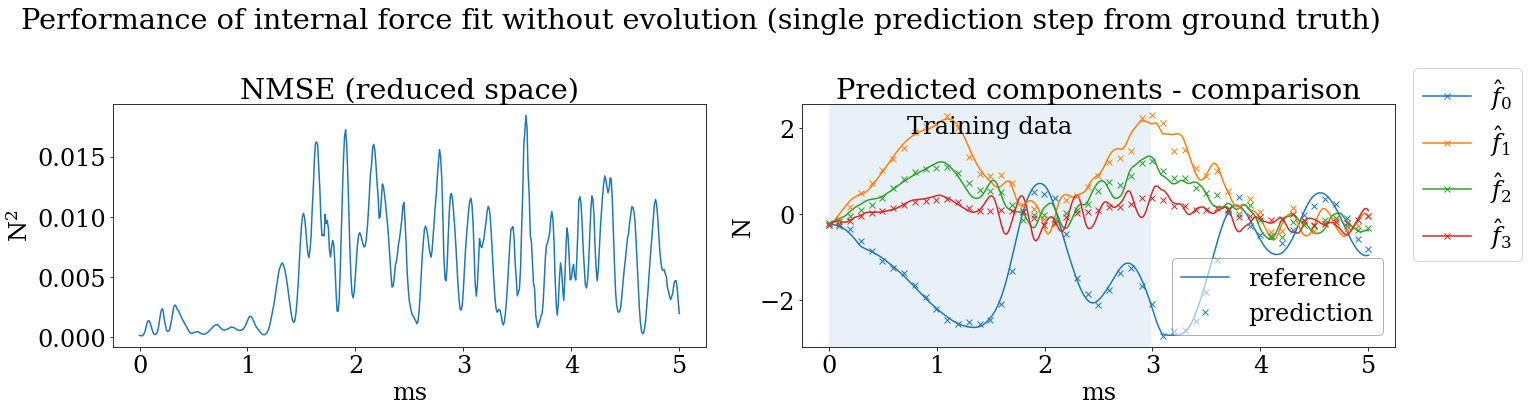

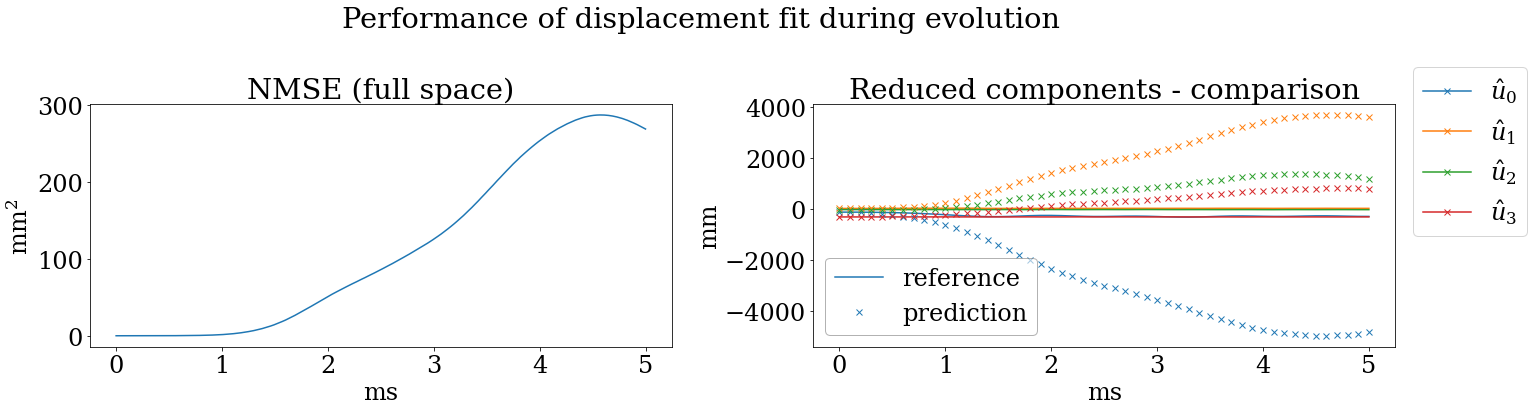

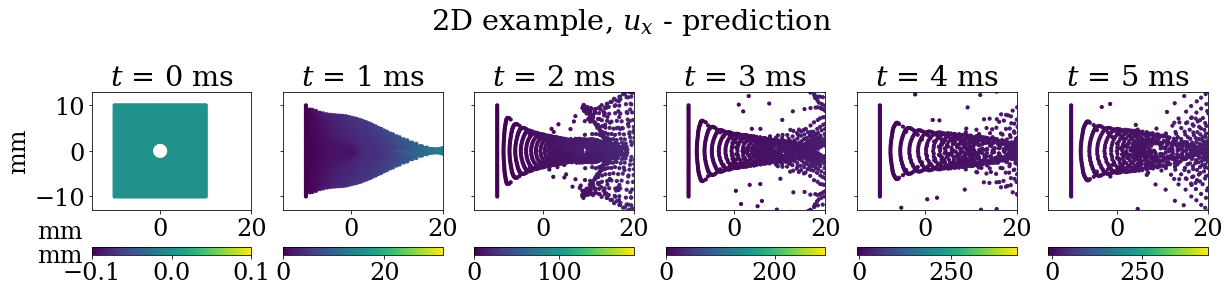

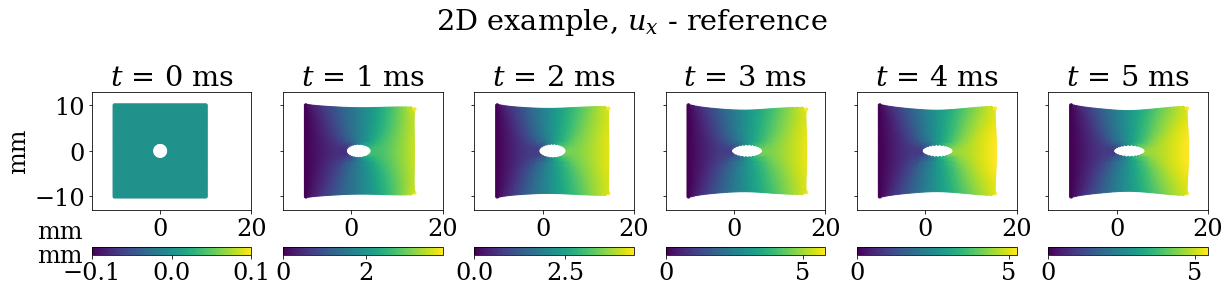

In [66]:
tf.random.set_seed(0)
fit_params = dict(batch_size=256, epochs=5000,verbose=2,validation_split=44/300,
                  callbacks=[EpochProgbar(100),tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=500,restore_best_weights=True)],
                  sample_weight=np.array([100] + [1]*299))

out = evaluate2D(mat2, tfRNN(npod_x,rnn_sizes=[32],rnn_activations=["tanh"],learning_rate=0.1),
                 *dr_oldf_ss_factory(9,6),
                 pod_basis_size=npod_x, training_stop=300, fit_params=fit_params, interrupt=False)

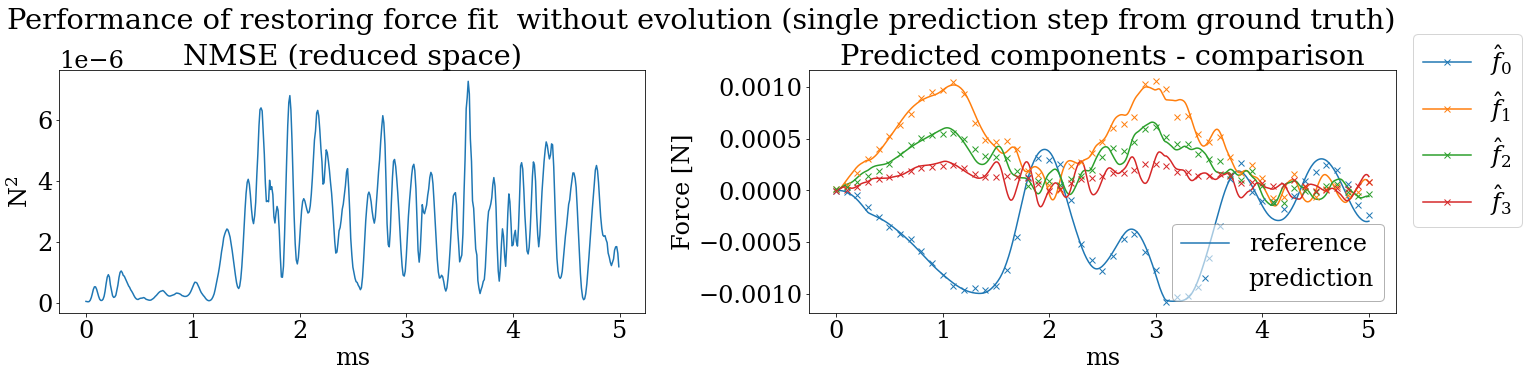

In [67]:
fint_test = fss_flat.inverse_transform_flat(out['pred_fint_r'][:,:npod_x])
tt = mat2.t[:fint_test.shape[0]]
plt.figure(figsize=(20,6))
plt.subplot(121)
plt.plot(tt[:-1], (((fint_test-mat2.fint_r[:fint_test.shape[0]])**2).mean(axis=1)/(fint_test.max()-fint_test.min()))[:-1])
plt.xlabel("ms")
plt.ylabel(r"N$^2$")
plt.title(f"NMSE (reduced space)");
plt.subplot(122)
l1 = plt.plot(mat2.t,mat2.fint_r)[0]
plt.gca().set_prop_cycle(None)
l2 = plt.plot(tt[::10],fint_test[::10],'x')[0]
plt.xlabel('ms')
plt.ylabel('Force [N]')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
legend1 = plt.legend(handles=[pltl.Line2D([0], [0],
                                            marker='x',
                                            color=colors[i % len(colors)],
                                            label=rf"$\hat{{f}}_{{{i}}}$") for i in range(mat2.fint_r.shape[1])],
                        loc="upper left",
                        bbox_to_anchor=(1.01,1.2))
plt.legend([l1,l2],['reference','prediction'],framealpha=0.6,edgecolor="gray")
plt.gca().add_artist(legend1)
plt.title("Predicted components - comparison")
plt.suptitle('Performance of restoring force fit  without evolution (single prediction step from ground truth)',y=0.9)
plt.tight_layout();

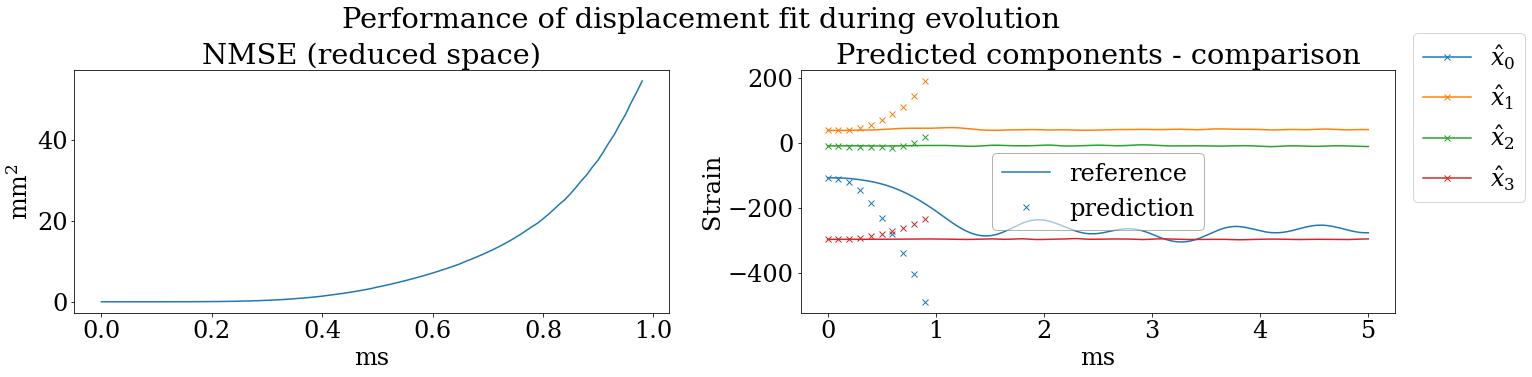

In [68]:
xrout = out['xrout'][:100]
t = mat2.t
tt = t[:xrout.shape[0]]
plt.figure(figsize=(20,6))
plt.subplot(121)
plt.plot(tt[:-1], (((xrout-mat2.xr[:xrout.shape[0]])**2).mean(axis=1)/(xrout.max()-xrout.min()))[:-1])
plt.xlabel("ms")
plt.ylabel(r"mm$^2$")
plt.title(f"NMSE (reduced space)");
plt.subplot(122)
l1 = plt.plot(t,mat2.xr)[0]
plt.gca().set_prop_cycle(None)
l2 = plt.plot(tt[::10],xrout[::10],'x')[0]
plt.xlabel('ms')
plt.ylabel('Strain')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
legend1 = plt.legend(handles=[pltl.Line2D([0], [0],
                                            marker='x',
                                            color=colors[i % len(colors)],
                                            label=rf"$\hat{{x}}_{{{i}}}$") for i in range(mat2.xr.shape[1])],
                        loc="upper left",
                        bbox_to_anchor=(1.01,1.2))
plt.legend([l1,l2],['reference','prediction'],framealpha=0.6,edgecolor="gray")
plt.gca().add_artist(legend1)
plt.title("Predicted components - comparison")
plt.suptitle('Performance of displacement fit during evolution',y=0.9)
plt.tight_layout();

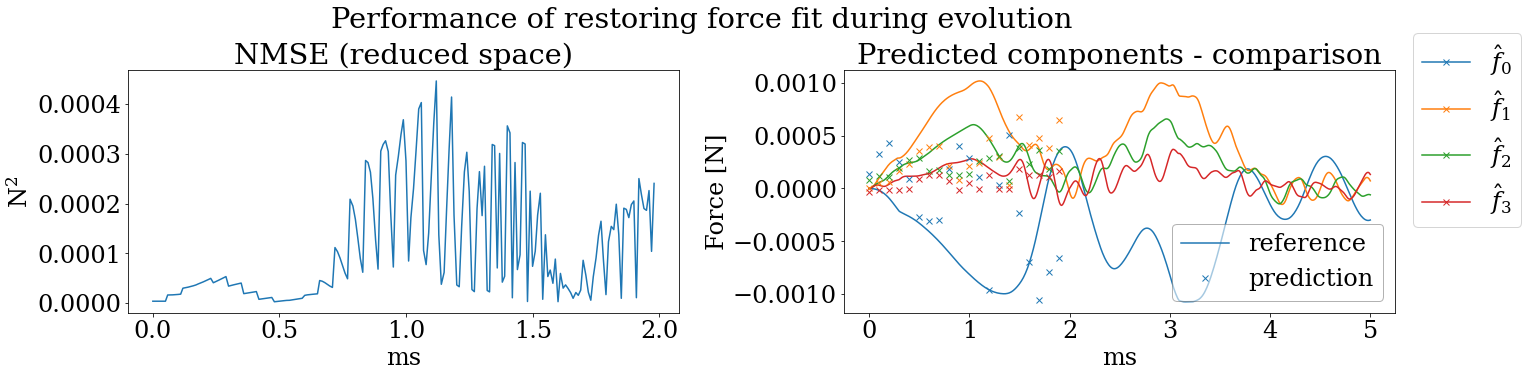

In [71]:
fint_test = out['hist'].fint_r_log[:200]
tt = mat2.t[:fint_test.shape[0]]
plt.figure(figsize=(20,6))
plt.subplot(121)
plt.plot(tt[:-1], (((fint_test-mat2.fint_r[:fint_test.shape[0]])**2).mean(axis=1)/(fint_test.max()-fint_test.min()))[:-1])
plt.xlabel("ms")
plt.ylabel(r"N$^2$")
plt.title(f"NMSE (reduced space)");
plt.subplot(122)
l1 = plt.plot(mat2.t,mat2.fint_r)[0]
plt.gca().set_prop_cycle(None)
l2 = plt.plot(tt[::10],fint_test[::10],'x')[0]
plt.xlabel('ms')
plt.ylabel('Force [N]')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
legend1 = plt.legend(handles=[pltl.Line2D([0], [0],
                                            marker='x',
                                            color=colors[i % len(colors)],
                                            label=rf"$\hat{{f}}_{{{i}}}$") for i in range(mat2.fint_r.shape[1])],
                        loc="upper left",
                        bbox_to_anchor=(1.01,1.2))
plt.legend([l1,l2],['reference','prediction'],framealpha=0.6,edgecolor="gray")
plt.gca().add_artist(legend1)
plt.title("Predicted components - comparison")
plt.suptitle('Performance of restoring force fit during evolution',y=0.9)
plt.tight_layout();

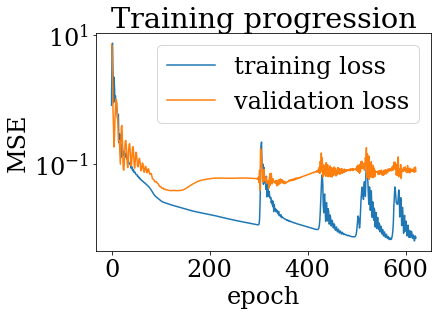

In [70]:
plt.figure()
plt.semilogy(out['fit_history'].history['loss'],label='training loss')
try:
    plt.semilogy(out['fit_history'].history['val_loss'],label='validation loss')
except:
    pass
plt.xlabel('epoch')
plt.ylabel("MSE")
plt.legend()
plt.title("Training progression");

## LSTMs

Evaluating:
	Training Data:	Example2D(plate/plate_2_20_20)
	Prediction Model:	<keras.engine.sequential.Sequential object at 0x000001824D1885B0>(Reduced displacement augmented with 54 previous steps at interval 1 step of restoring force with Scaling, Reduced Internal force)
	Acceleration function:	Prediction from displacement augmented with 54 previous steps at interval 1 step of restoring force with Scaling
	POD components:	4
	Training range:	0:300/501
Epoch 100/5000
100/100 - 0s - loss: 0.0677 - val_loss: 0.1637 - 344ms/epoch - 3ms/sample
Epoch 200/5000
100/100 - 0s - loss: 0.0712 - val_loss: 0.1792 - 312ms/epoch - 3ms/sample
Epoch 300/5000
100/100 - 0s - loss: 0.0203 - val_loss: 0.3495 - 328ms/epoch - 3ms/sample
Epoch 400/5000
100/100 - 0s - loss: 0.0175 - val_loss: 0.3877 - 317ms/epoch - 3ms/sample
Epoch 500/5000
100/100 - 0s - loss: 0.0130 - val_loss: 0.3659 - 332ms/epoch - 3ms/sample


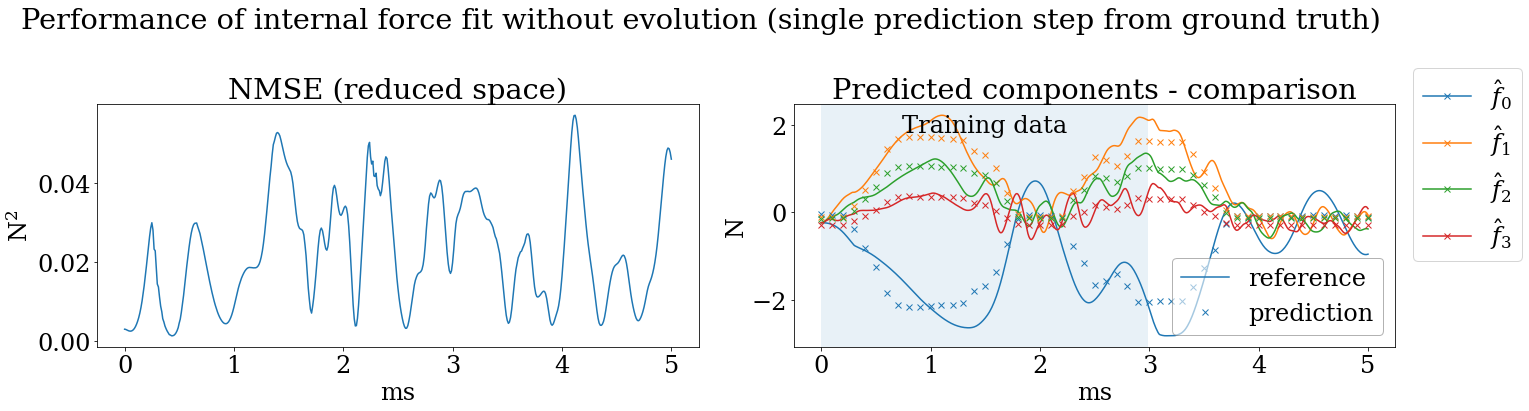

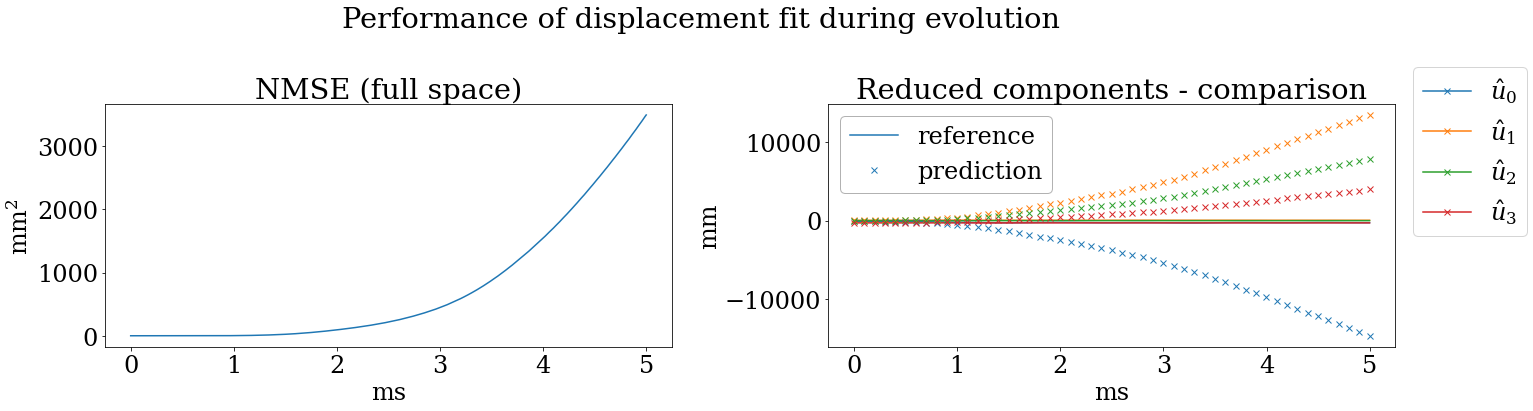

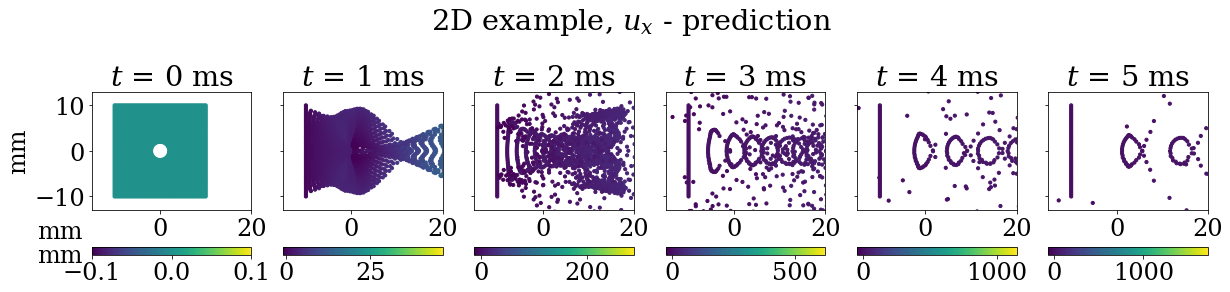

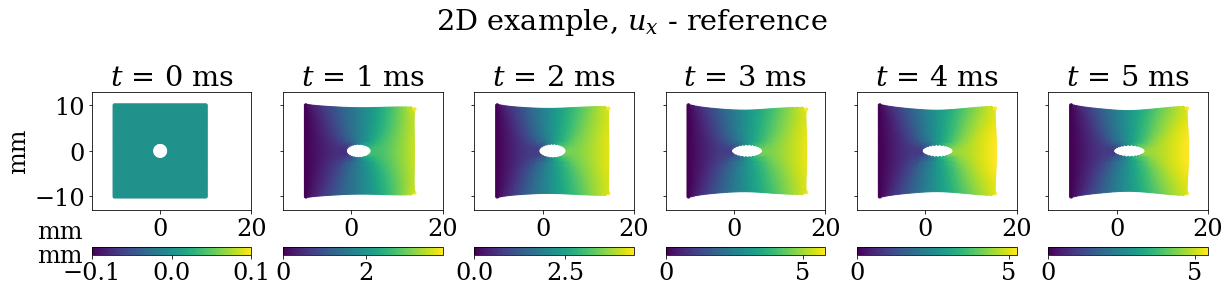

In [87]:
tf.random.set_seed(0)
fit_params = dict(batch_size=256, epochs=5000,verbose=2,validation_split=44/300,
                  callbacks=[EpochProgbar(100),tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=500,restore_best_weights=True)],
                  sample_weight=np.array([100] + [1]*299))

out = evaluate2D(mat2, tfLSTM(npod_x,rnn_sizes=[16,24,32,24],rnn_activations=["tanh"]*4,learning_rate=0.1),
                 *dr_oldf_ss_factory(54,1),
                 pod_basis_size=npod_x, training_stop=300, fit_params=fit_params, interrupt=False)

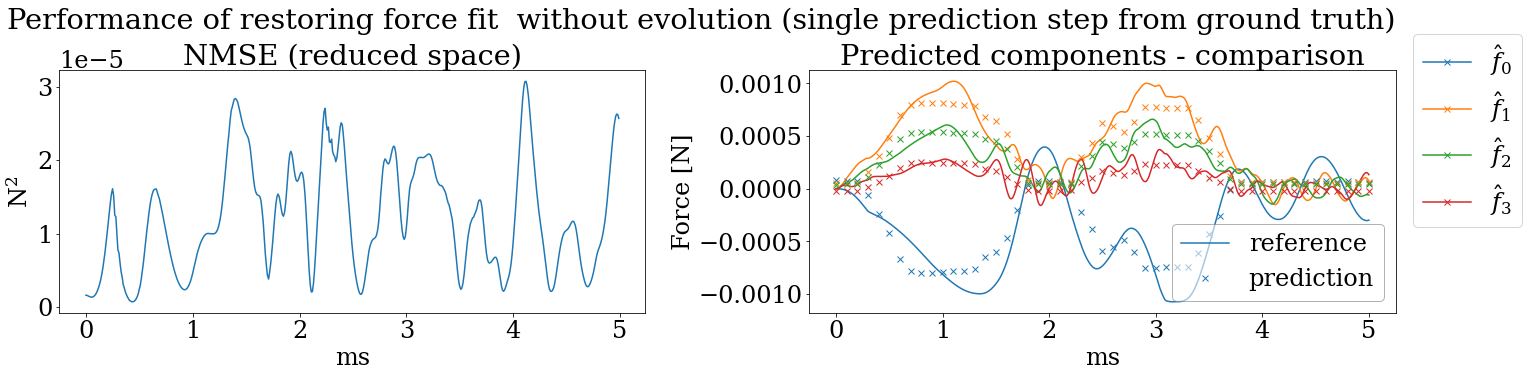

In [88]:
fint_test = fss_flat.inverse_transform_flat(out['pred_fint_r'][:,:npod_x])
tt = mat2.t[:fint_test.shape[0]]
plt.figure(figsize=(20,6))
plt.subplot(121)
plt.plot(tt[:-1], (((fint_test-mat2.fint_r[:fint_test.shape[0]])**2).mean(axis=1)/(fint_test.max()-fint_test.min()))[:-1])
plt.xlabel("ms")
plt.ylabel(r"N$^2$")
plt.title(f"NMSE (reduced space)");
plt.subplot(122)
l1 = plt.plot(mat2.t,mat2.fint_r)[0]
plt.gca().set_prop_cycle(None)
l2 = plt.plot(tt[::10],fint_test[::10],'x')[0]
plt.xlabel('ms')
plt.ylabel('Force [N]')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
legend1 = plt.legend(handles=[pltl.Line2D([0], [0],
                                            marker='x',
                                            color=colors[i % len(colors)],
                                            label=rf"$\hat{{f}}_{{{i}}}$") for i in range(mat2.fint_r.shape[1])],
                        loc="upper left",
                        bbox_to_anchor=(1.01,1.2))
plt.legend([l1,l2],['reference','prediction'],framealpha=0.6,edgecolor="gray")
plt.gca().add_artist(legend1)
plt.title("Predicted components - comparison")
plt.suptitle('Performance of restoring force fit  without evolution (single prediction step from ground truth)',y=0.9)
plt.tight_layout();

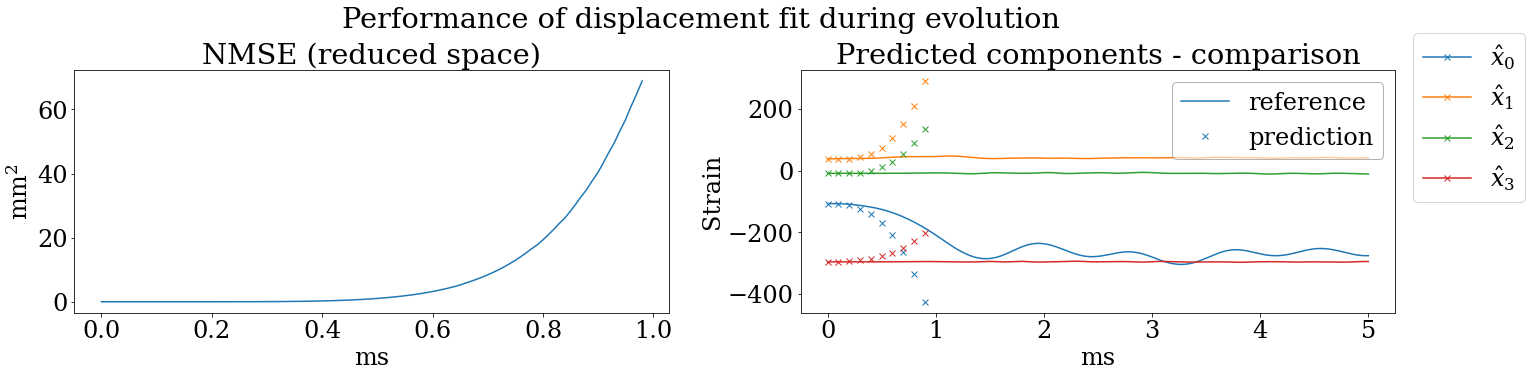

In [89]:
xrout = out['xrout'][:100]
t = mat2.t
tt = t[:xrout.shape[0]]
plt.figure(figsize=(20,6))
plt.subplot(121)
plt.plot(tt[:-1], (((xrout-mat2.xr[:xrout.shape[0]])**2).mean(axis=1)/(xrout.max()-xrout.min()))[:-1])
plt.xlabel("ms")
plt.ylabel(r"mm$^2$")
plt.title(f"NMSE (reduced space)");
plt.subplot(122)
l1 = plt.plot(t,mat2.xr)[0]
plt.gca().set_prop_cycle(None)
l2 = plt.plot(tt[::10],xrout[::10],'x')[0]
plt.xlabel('ms')
plt.ylabel('Strain')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
legend1 = plt.legend(handles=[pltl.Line2D([0], [0],
                                            marker='x',
                                            color=colors[i % len(colors)],
                                            label=rf"$\hat{{x}}_{{{i}}}$") for i in range(mat2.xr.shape[1])],
                        loc="upper left",
                        bbox_to_anchor=(1.01,1.2))
plt.legend([l1,l2],['reference','prediction'],framealpha=0.6,edgecolor="gray")
plt.gca().add_artist(legend1)
plt.title("Predicted components - comparison")
plt.suptitle('Performance of displacement fit during evolution',y=0.9)
plt.tight_layout();

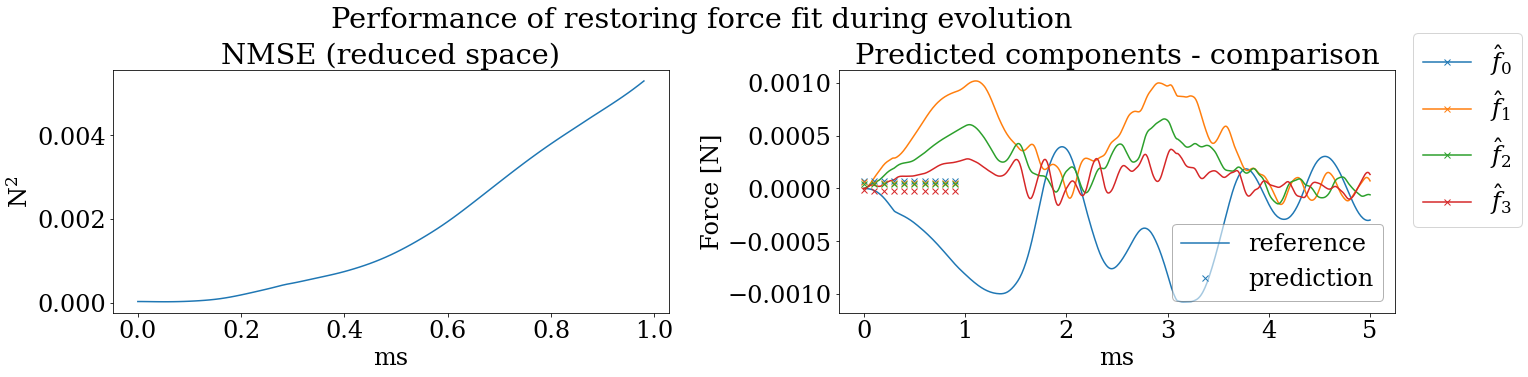

In [90]:
fint_test = out['hist'].fint_r_log[:100]
tt = mat2.t[:fint_test.shape[0]]
plt.figure(figsize=(20,6))
plt.subplot(121)
plt.plot(tt[:-1], (((fint_test-mat2.fint_r[:fint_test.shape[0]])**2).mean(axis=1)/(fint_test.max()-fint_test.min()))[:-1])
plt.xlabel("ms")
plt.ylabel(r"N$^2$")
plt.title(f"NMSE (reduced space)");
plt.subplot(122)
l1 = plt.plot(mat2.t,mat2.fint_r)[0]
plt.gca().set_prop_cycle(None)
l2 = plt.plot(tt[::10],fint_test[::10],'x')[0]
plt.xlabel('ms')
plt.ylabel('Force [N]')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
legend1 = plt.legend(handles=[pltl.Line2D([0], [0],
                                            marker='x',
                                            color=colors[i % len(colors)],
                                            label=rf"$\hat{{f}}_{{{i}}}$") for i in range(mat2.fint_r.shape[1])],
                        loc="upper left",
                        bbox_to_anchor=(1.01,1.2))
plt.legend([l1,l2],['reference','prediction'],framealpha=0.6,edgecolor="gray")
plt.gca().add_artist(legend1)
plt.title("Predicted components - comparison")
plt.suptitle('Performance of restoring force fit during evolution',y=0.9)
plt.tight_layout();

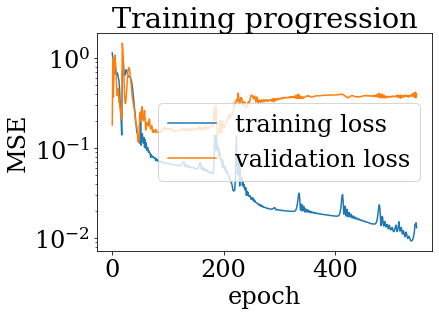

In [91]:
plt.figure()
plt.semilogy(out['fit_history'].history['loss'],label='training loss')
try:
    plt.semilogy(out['fit_history'].history['val_loss'],label='validation loss')
except:
    pass
plt.xlabel('epoch')
plt.ylabel("MSE")
plt.legend()
plt.title("Training progression");

Evaluating:
	Training Data:	Example2D(plate/plate_2_20_20)
	Prediction Model:	<keras.engine.sequential.Sequential object at 0x0000022F144A94F0>(Reduced displacement augmented with 9 previous steps at interval 6 step of restoring force with Scaling, Reduced Internal force)
	Acceleration function:	Prediction from displacement augmented with 9 previous steps at interval 6 step of restoring force with Scaling
	POD components:	4
	Training range:	0:300/501
Epoch 100/5000
100/100 - 0s - loss: 0.0245 - val_loss: 0.2163 - 92ms/epoch - 915us/sample
Epoch 200/5000
100/100 - 0s - loss: 0.0022 - val_loss: 0.3600 - 102ms/epoch - 1ms/sample
Epoch 300/5000
100/100 - 0s - loss: 0.0010 - val_loss: 0.4235 - 106ms/epoch - 1ms/sample
Epoch 400/5000
100/100 - 0s - loss: 7.7691e-04 - val_loss: 0.4178 - 348ms/epoch - 3ms/sample
Epoch 500/5000
100/100 - 0s - loss: 2.6302e-04 - val_loss: 0.4248 - 139ms/epoch - 1ms/sample


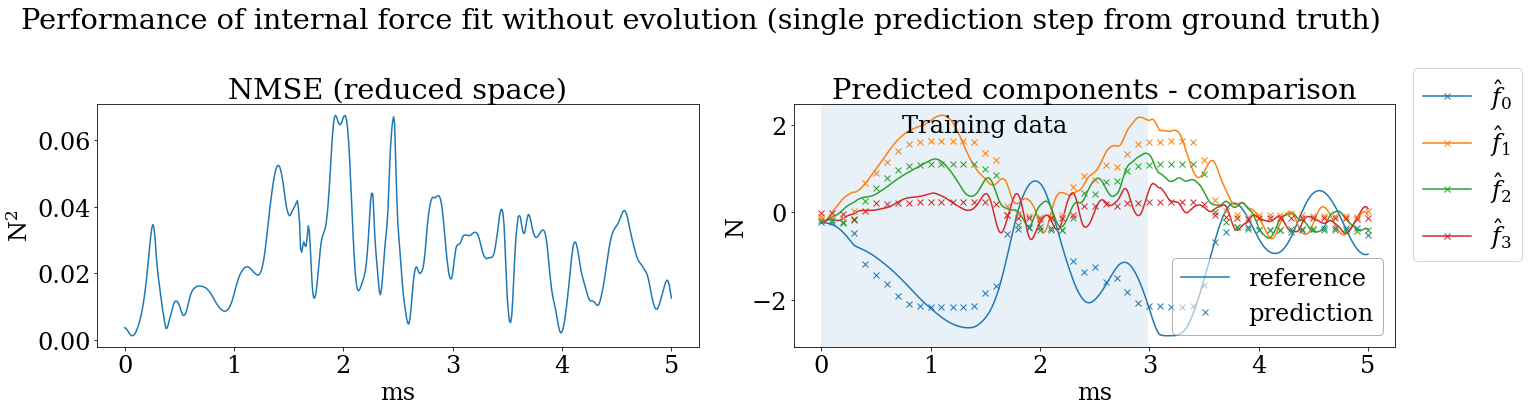

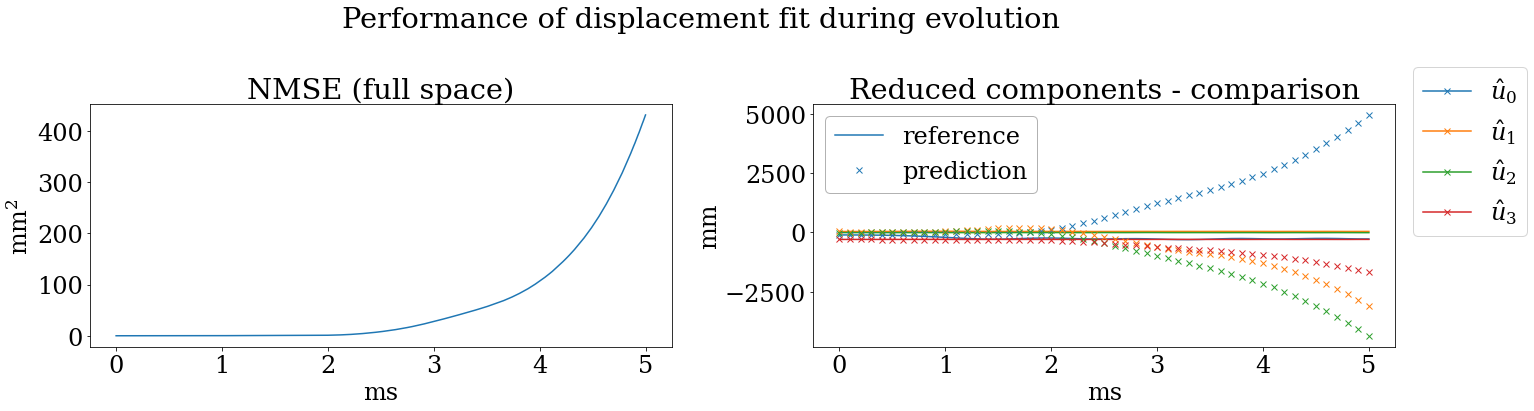

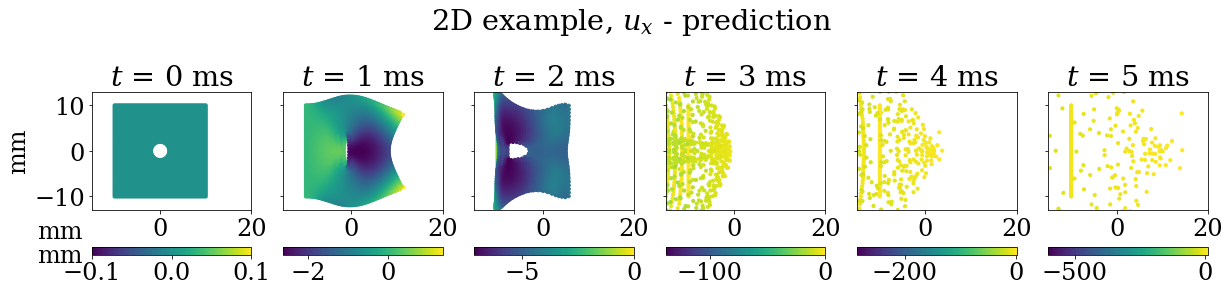

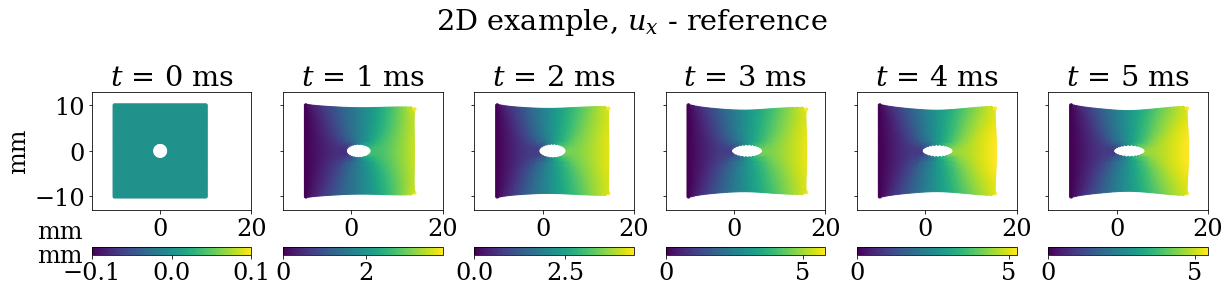

In [30]:
tf.random.set_seed(0)
fit_params = dict(batch_size=256, epochs=5000,verbose=2,validation_split=44/300,
                  callbacks=[EpochProgbar(100),tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=500,restore_best_weights=True)],
                  sample_weight=np.array([100] + [1]*299))

out = evaluate2D(mat2, tfLSTM(npod_x,rnn_sizes=[16,24,32,24],rnn_activations=["tanh"]*4,learning_rate=0.1),
                 *dr_oldf_ss_factory(9,6),
                 pod_basis_size=npod_x, training_stop=300, fit_params=fit_params, interrupt=False)

'Saved to ../animations/plastic_lstm_4pods.gif'

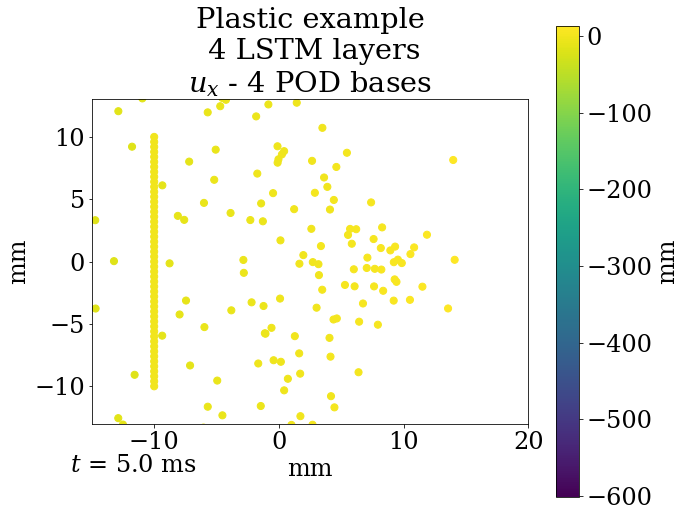

In [26]:
xroutinv = out['xroutinv']
dx_xroutinv = (xroutinv - xroutinv[0])[:,:xroutinv.shape[1]//2]
xx_xroutinv = mat2.xx[0] + xroutinv - xroutinv[0]
animatedplot2D(dx_xroutinv, xx_xroutinv[:,:xx_xroutinv.shape[1]//2],xx_xroutinv[:,xx_xroutinv.shape[1]//2:],
                path = "../animations/plastic_lstm_4pods",
                title = "Plastic example\n 4 LSTM layers\n" r"$u_x$ - 4 POD bases",
               total_frames=250)

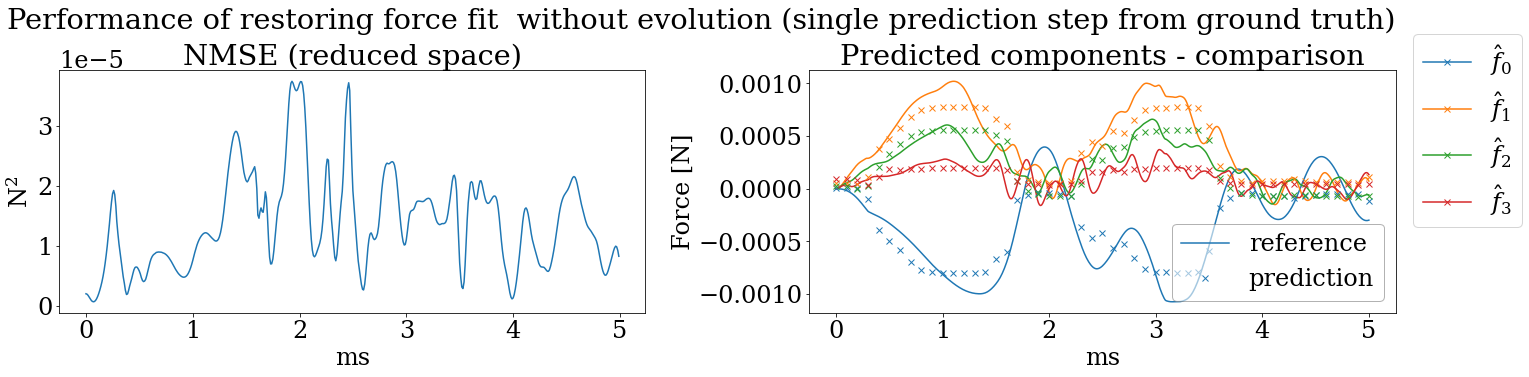

In [93]:
fint_test = fss_flat.inverse_transform_flat(out['pred_fint_r'][:,:npod_x])
tt = mat2.t[:fint_test.shape[0]]
plt.figure(figsize=(20,6))
plt.subplot(121)
plt.plot(tt[:-1], (((fint_test-mat2.fint_r[:fint_test.shape[0]])**2).mean(axis=1)/(fint_test.max()-fint_test.min()))[:-1])
plt.xlabel("ms")
plt.ylabel(r"N$^2$")
plt.title(f"NMSE (reduced space)");
plt.subplot(122)
l1 = plt.plot(mat2.t,mat2.fint_r)[0]
plt.gca().set_prop_cycle(None)
l2 = plt.plot(tt[::10],fint_test[::10],'x')[0]
plt.xlabel('ms')
plt.ylabel('Force [N]')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
legend1 = plt.legend(handles=[pltl.Line2D([0], [0],
                                            marker='x',
                                            color=colors[i % len(colors)],
                                            label=rf"$\hat{{f}}_{{{i}}}$") for i in range(mat2.fint_r.shape[1])],
                        loc="upper left",
                        bbox_to_anchor=(1.01,1.2))
plt.legend([l1,l2],['reference','prediction'],framealpha=0.6,edgecolor="gray")
plt.gca().add_artist(legend1)
plt.title("Predicted components - comparison")
plt.suptitle('Performance of restoring force fit  without evolution (single prediction step from ground truth)',y=0.9)
plt.tight_layout();

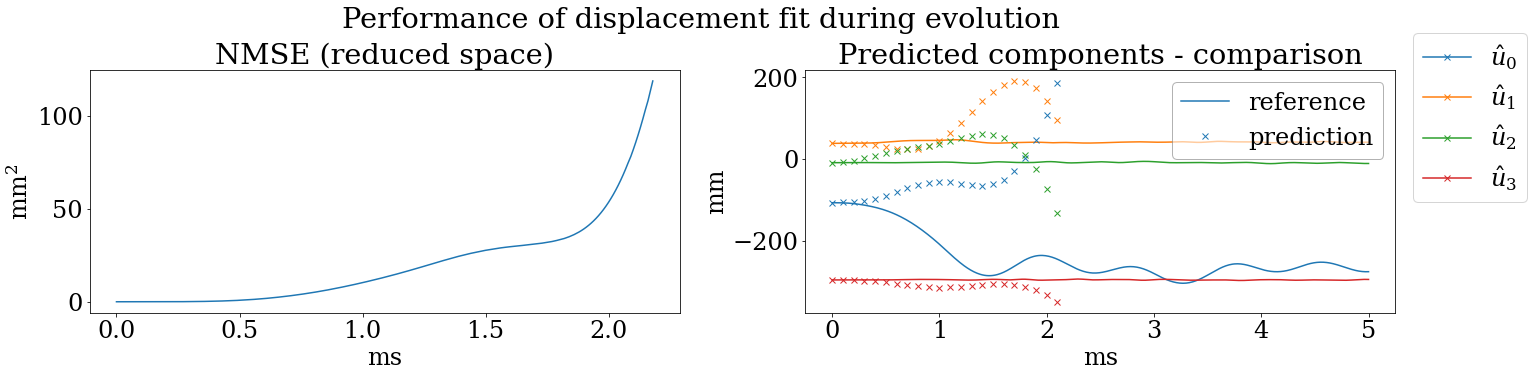

In [31]:
xrout = out['xrout'][:220]
t = mat2.t
tt = t[:xrout.shape[0]]
plt.figure(figsize=(20,6))
plt.subplot(121)
plt.plot(tt[:-1], (((xrout-mat2.xr[:xrout.shape[0]])**2).mean(axis=1)/(xrout.max()-xrout.min()))[:-1])
plt.xlabel("ms")
plt.ylabel(r"mm$^2$")
plt.title(f"NMSE (reduced space)");
plt.subplot(122)
l1 = plt.plot(t,mat2.xr)[0]
plt.gca().set_prop_cycle(None)
l2 = plt.plot(tt[::10],xrout[::10],'x')[0]
plt.xlabel('ms')
plt.ylabel('mm')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
legend1 = plt.legend(handles=[pltl.Line2D([0], [0],
                                            marker='x',
                                            color=colors[i % len(colors)],
                                            label=rf"$\hat{{u}}_{{{i}}}$") for i in range(mat2.xr.shape[1])],
                        loc="upper left",
                        bbox_to_anchor=(1.01,1.2))
plt.legend([l1,l2],['reference','prediction'],framealpha=0.6,edgecolor="gray")
plt.gca().add_artist(legend1)
plt.title("Predicted components - comparison")
plt.suptitle('Performance of displacement fit during evolution',y=0.9)
plt.tight_layout();

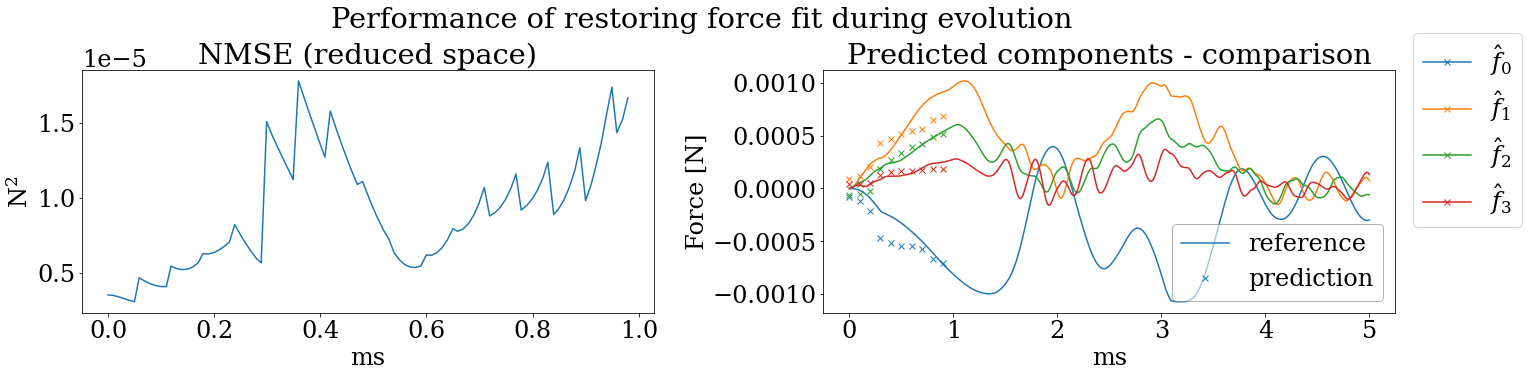

In [95]:
fint_test = out['hist'].fint_r_log[:100]
tt = mat2.t[:fint_test.shape[0]]
plt.figure(figsize=(20,6))
plt.subplot(121)
plt.plot(tt[:-1], (((fint_test-mat2.fint_r[:fint_test.shape[0]])**2).mean(axis=1)/(fint_test.max()-fint_test.min()))[:-1])
plt.xlabel("ms")
plt.ylabel(r"N$^2$")
plt.title(f"NMSE (reduced space)");
plt.subplot(122)
l1 = plt.plot(mat2.t,mat2.fint_r)[0]
plt.gca().set_prop_cycle(None)
l2 = plt.plot(tt[::10],fint_test[::10],'x')[0]
plt.xlabel('ms')
plt.ylabel('Force [N]')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
legend1 = plt.legend(handles=[pltl.Line2D([0], [0],
                                            marker='x',
                                            color=colors[i % len(colors)],
                                            label=rf"$\hat{{f}}_{{{i}}}$") for i in range(mat2.fint_r.shape[1])],
                        loc="upper left",
                        bbox_to_anchor=(1.01,1.2))
plt.legend([l1,l2],['reference','prediction'],framealpha=0.6,edgecolor="gray")
plt.gca().add_artist(legend1)
plt.title("Predicted components - comparison")
plt.suptitle('Performance of restoring force fit during evolution',y=0.9)
plt.tight_layout();

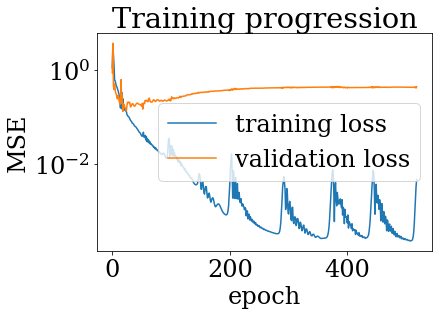

In [96]:
plt.figure()
plt.semilogy(out['fit_history'].history['loss'],label='training loss')
try:
    plt.semilogy(out['fit_history'].history['val_loss'],label='validation loss')
except:
    pass
plt.xlabel('epoch')
plt.ylabel("MSE")
plt.legend()
plt.title("Training progression");